![截圖 2025-05-19 下午5.22.43.png](<attachment:截圖 2025-05-19 下午5.22.43.png>)
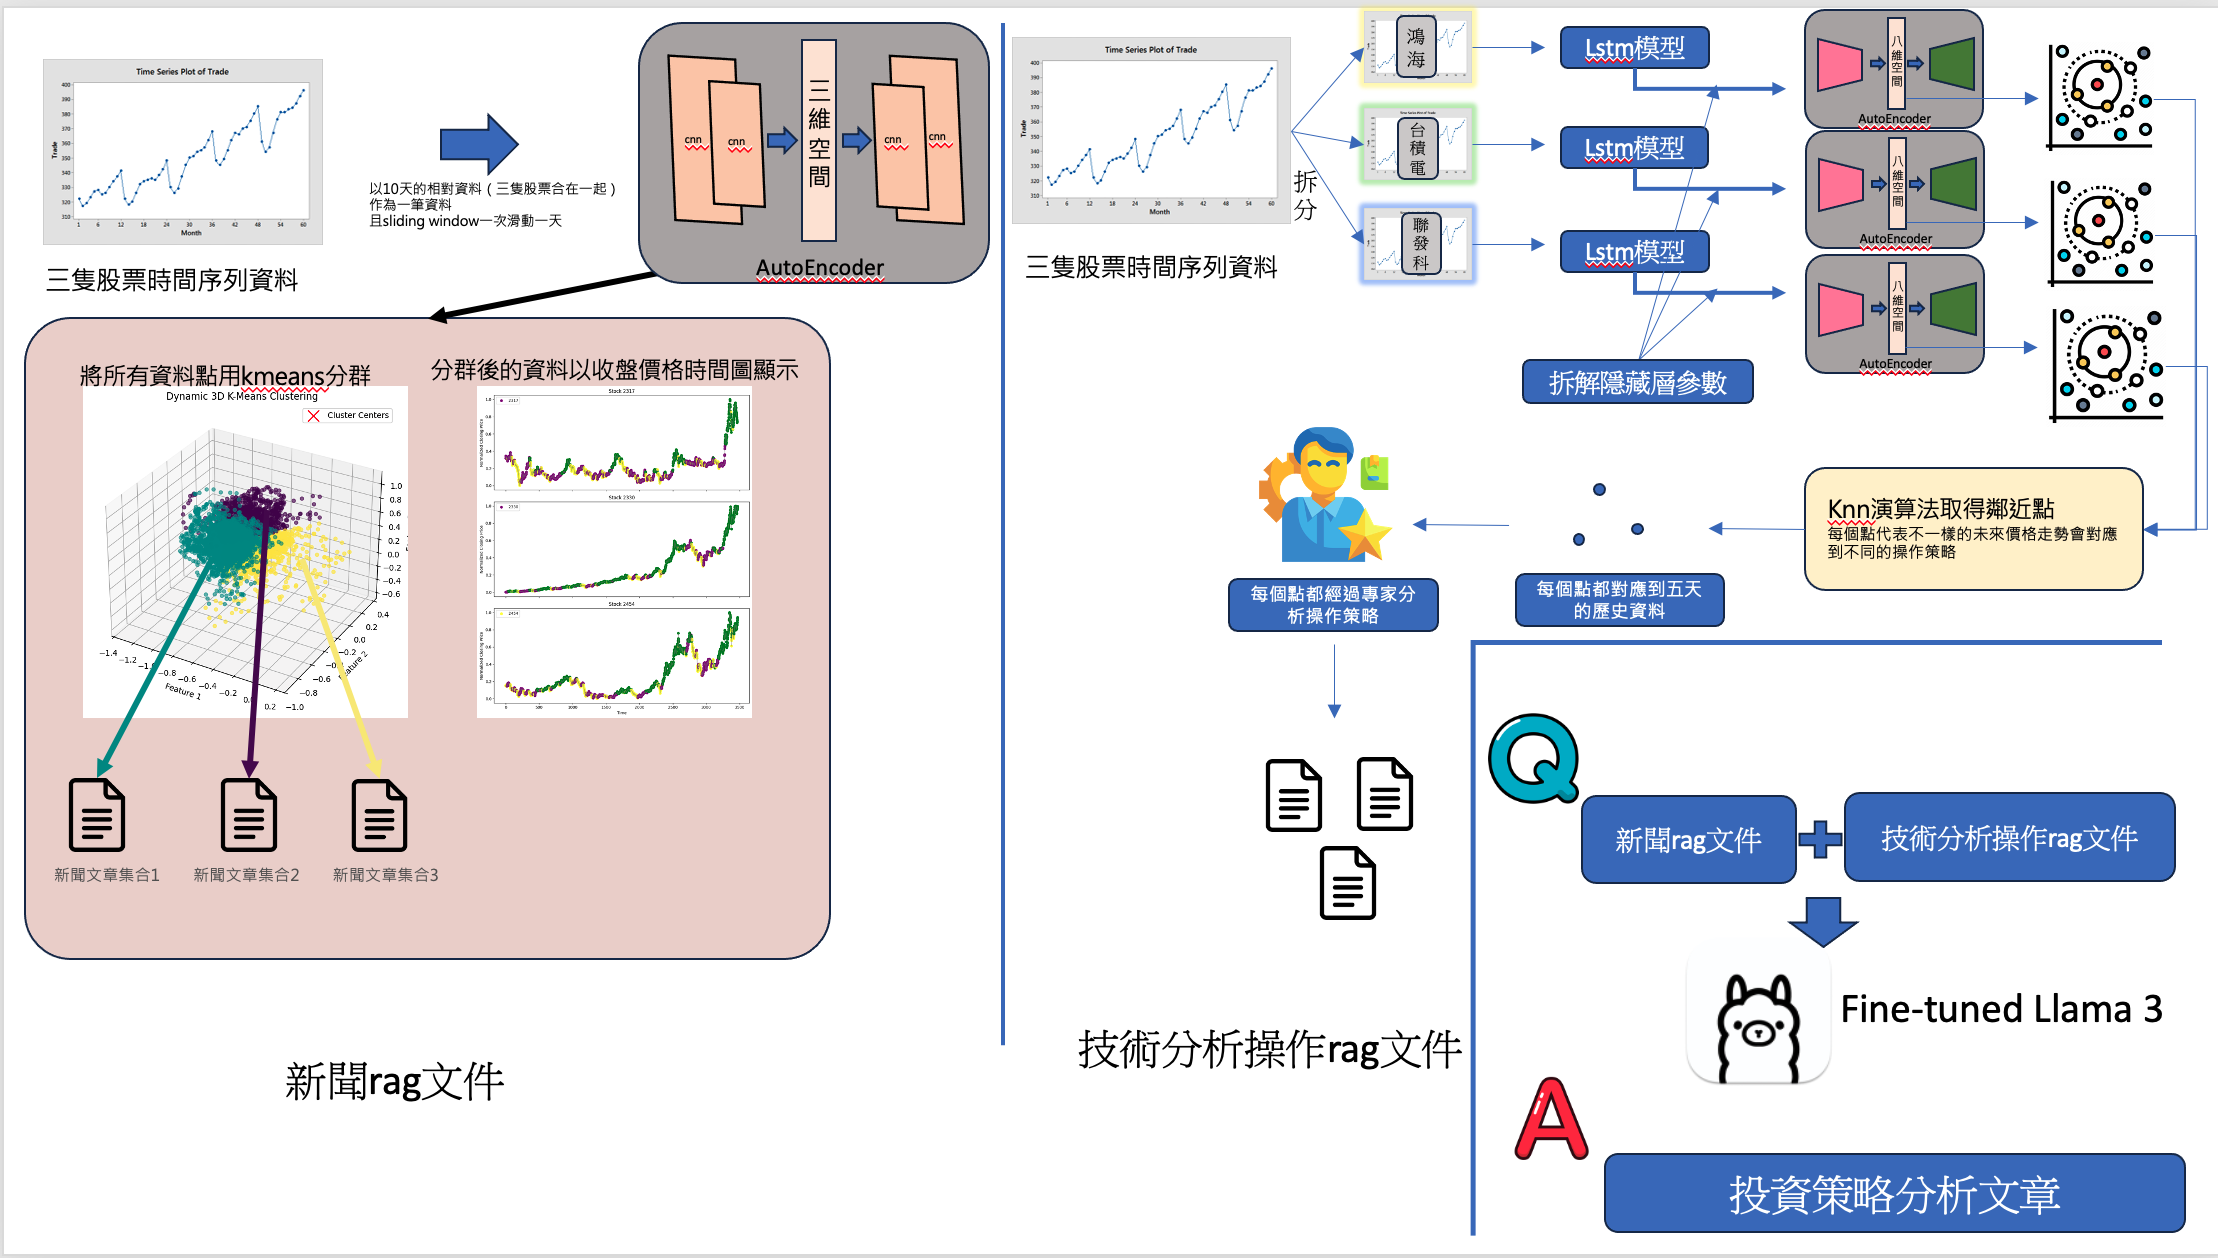

獲得推論用資料

一、新聞文章部份

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# 讀取 CSV 檔案
file_path = "../1.資料前處理/merged_stocks_sorted（for推論）.csv"
df = pd.read_csv(file_path)
print(df.head())

           日期        成交股數            成交金額     開盤價     最高價     最低價     收盤價  \
0  2024-12-03  52,170,125  10,312,565,933   198.5   200.0   196.5   196.5   
1  2024-12-03  48,632,084  51,509,603,939  1060.0  1065.0  1055.0  1055.0   
2  2024-12-03   6,211,010   8,141,226,882  1325.0  1330.0  1295.0  1315.0   
3  2024-12-04  50,379,504  10,055,268,944   197.5   201.5   197.0   201.0   
4  2024-12-04  35,431,584  37,738,286,825  1065.0  1070.0  1055.0  1070.0   

     漲跌價差    成交筆數   SMA_5  ...    SMA_200        EMA_5       EMA_20  \
0     0.5  47,992   196.0  ...   175.6825   197.283592   203.025649   
1  +20.00  55,988  1018.2  ...   902.0250  1029.121972  1029.703911   
2   +5.00   7,911  1277.0  ...  1208.1800  1290.285435  1278.528410   
3     4.5  32,459   196.9  ...   176.1725   198.522394   202.832730   
4  +15.00  45,553  1032.2  ...   904.2350  1042.747981  1033.541634   

         RSI      MACD  MACD_signal  MACD_hist  Support_Level  \
0  40.566207 -2.642548    -0.796847  -1.84570

計算與上個交易日的價格變化

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 確保日期是正確的格式並排序
df['日期'] = pd.to_datetime(df['日期'])
df = df.sort_values(by=['日期','股票代碼'])

# 定義需要計算變化的數值型欄位
numeric_cols = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 
                'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 
                'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level', 'Resistance_Level']

# 數據前處理
df[numeric_cols] = df[numeric_cols].replace("X0.00", "0")

# 移除 `,` 並轉換為 float
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)


# 創建合併後的 DataFrame，首先複製原始數據
merged_df = df.copy()

# 對漲跌價差進行 MinMax 縮放 (針對每支股票分別處理)
scaler = MinMaxScaler()
for stock_id in merged_df['股票代碼'].unique():
    mask = merged_df['股票代碼'] == stock_id
    # 將漲跌價差重塑為二維陣列（sklearn要求的格式）
    price_diff = merged_df.loc[mask, '漲跌價差'].values.reshape(-1, 1)
    # 進行 MinMax 縮放
    scaled_diff = scaler.fit_transform(price_diff)
    # 將縮放後的值存回 DataFrame
    merged_df.loc[mask, '漲跌價差_pct'] = scaled_diff.flatten()

# 計算其他欄位的百分比變化
for col in [c for c in numeric_cols if c != '漲跌價差']:
    merged_df[f'{col}_pct'] = df.groupby('股票代碼')[col].pct_change() * 100



# 移除含有 NaN 的行
merged_df = merged_df.dropna()

# 查看結果
print("合併後資料的前5筆：")
print(merged_df.head())

# 檢查資料形狀
print("\n資料形狀：", merged_df.shape)

# 檢查是否有任何無限值
inf_count = np.sum(np.isinf(merged_df.select_dtypes(include=[np.number])))
print("\n無限值數量：", inf_count)

# 儲存結果
merged_df.to_csv('新聞部份/stock_data_with_changes.csv', index=False)

# 顯示各欄位數據類型
print("\n各欄位數據類型：")
print(merged_df.dtypes)

合併後資料的前5筆：
          日期        成交股數          成交金額     開盤價     最高價     最低價     收盤價  漲跌價差  \
3 2024-12-04  50379504.0  1.005527e+10   197.5   201.5   197.0   201.0   4.5   
4 2024-12-04  35431584.0  3.773829e+10  1065.0  1070.0  1055.0  1070.0  15.0   
5 2024-12-04   4844752.0  6.364952e+09  1315.0  1325.0  1305.0  1320.0   5.0   
6 2024-12-05  46475440.0  9.319677e+09   203.0   203.5   199.0   199.0  -2.0   
7 2024-12-05  41293183.0  4.442033e+10  1070.0  1080.0  1070.0  1075.0   5.0   

      成交筆數   SMA_5  ...  SMA_50_pct  SMA_200_pct  EMA_5_pct  EMA_20_pct  \
3  32459.0   196.9  ...    0.241653     0.278912   0.627930   -0.095022   
4  45553.0  1032.2  ...    0.213638     0.245004   1.324042    0.372702   
5   6345.0  1291.0  ...    0.316081     0.161400   0.767648    0.308924   
6  47064.0   197.6  ...    0.216472     0.275298   0.080193   -0.179962   
7  51311.0  1046.2  ...    0.197678     0.243300   1.030994    0.382028   

     RSI_pct    MACD_pct  MACD_signal_pct  MACD_hist_pct 

/home/r11011101/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [11]:
def create_sequences(df, seq_length=10):
    sequences = []
    start_dates = []
    stock_ids = []
    close_prices = []  # 新增收盤價列表
    
    # 只選取需要的欄位 (保留股票代碼和收盤價)
    features = [col for col in df.columns if col.endswith('_pct')]
    df = df[['日期', '股票代碼', '收盤價'] + features]
    
    # 輸出除錯資訊
    print(f"特徵數量: {len(features)}")
    print(f"特徵名稱: {features}")
    
    # 對每個股票分別處理
    for stock_id in df['股票代碼'].unique():
        stock_data = df[df['股票代碼'] == stock_id].sort_values('日期')
        print(f"\n處理股票 {stock_id}")
        print(f"該股票資料筆數: {len(stock_data)}")
        
        # 創建滑動窗口
        for i in range(len(stock_data) - seq_length + 1):
            # 取得當前窗口的數據
            sequence = stock_data.iloc[i:i+seq_length]
            
            # 檢查是否有足夠的數據點
            if len(sequence) == seq_length:
                # 保留特徵數據和股票代碼
                seq_features = sequence[features].values
                sequences.append(seq_features)
                # 記錄序列的起始日期、股票代碼和收盤價
                dates = pd.to_datetime(sequence['日期'])
                start_dates.append(dates.iloc[0])
                stock_ids.append(stock_id)
                close_prices.append(sequence['收盤價'].iloc[0])  # 添加起始日的收盤價
                
                if len(sequences) == 1:  # 輸出第一個成功的序列資訊
                    print(f"成功創建第一個序列，形狀: {seq_features.shape}")
                    print(f"序列日期範圍: {dates.iloc[0]} 到 {dates.iloc[-1]}")
                    print(f"起始日收盤價: {close_prices[0]}")
        
        print(f"該股票產生的序列數: {sum(1 for x in stock_ids if x == stock_id)}")
    
    # 檢查是否有序列被創建
    if not sequences:
        print("警告：沒有找到符合條件的序列")
        return pd.DataFrame()
    
    # 轉換為 numpy array
    sequences = np.array(sequences)
    
    # 創建包含起始日期、股票代碼和收盤價的 DataFrame
    sequences_df = pd.DataFrame({
        'start_date': start_dates,
        'stock_id': stock_ids,
        'close_price': close_prices,  # 添加收盤價欄位
        'sequence': list(sequences)
    })
    
    return sequences_df

# 創建序列數據
sequences_df = create_sequences(merged_df)

# 顯示結果
if not sequences_df.empty:
    print("\n成功創建序列:")
    print(f"序列數據總數: {len(sequences_df)}")
    print("\n前幾筆資料:")
    print(sequences_df[['start_date', 'stock_id', 'close_price']].head())
    print("\n第一個序列的形狀:", sequences_df['sequence'].iloc[0].shape)

特徵數量: 21
特徵名稱: ['漲跌價差_pct', '成交股數_pct', '成交金額_pct', '開盤價_pct', '最高價_pct', '最低價_pct', '收盤價_pct', '成交筆數_pct', 'SMA_5_pct', 'SMA_20_pct', 'SMA_60_pct', 'SMA_50_pct', 'SMA_200_pct', 'EMA_5_pct', 'EMA_20_pct', 'RSI_pct', 'MACD_pct', 'MACD_signal_pct', 'MACD_hist_pct', 'Support_Level_pct', 'Resistance_Level_pct']

處理股票 2317
該股票資料筆數: 63
成功創建第一個序列，形狀: (10, 21)
序列日期範圍: 2024-12-04 00:00:00 到 2024-12-17 00:00:00
起始日收盤價: 201.0
該股票產生的序列數: 54

處理股票 2330
該股票資料筆數: 63
該股票產生的序列數: 54

處理股票 2454
該股票資料筆數: 63
該股票產生的序列數: 54

成功創建序列:
序列數據總數: 162

前幾筆資料:
  start_date  stock_id  close_price
0 2024-12-04      2317        201.0
1 2024-12-05      2317        199.0
2 2024-12-06      2317        198.0
3 2024-12-09      2317        195.0
4 2024-12-10      2317        192.0

第一個序列的形狀: (10, 21)


In [12]:
print(sequences_df.head())
print(sequences_df.tail())
print(sequences_df['sequence'].iloc[0].shape)
print(sequences_df['sequence'].iloc[0])
print(sequences_df.shape)
#sequences_df.to_csv('sequences_df.csv', index=False)

  start_date  stock_id  close_price  \
0 2024-12-04      2317        201.0   
1 2024-12-05      2317        199.0   
2 2024-12-06      2317        198.0   
3 2024-12-09      2317        195.0   
4 2024-12-10      2317        192.0   

                                            sequence  
0  [[0.926829268292683, -3.4322727806383457, -2.4...  
1  [[0.6097560975609757, -7.749310116272678, -7.3...  
2  [[0.6585365853658537, 2.26160742103787, 1.5601...  
3  [[0.5609756097560976, -13.491887015867265, -14...  
4  [[0.5609756097560976, 43.488132816835105, 40.7...  
    start_date  stock_id  close_price  \
157 2025-02-21      2454       1510.0   
158 2025-02-24      2454       1545.0   
159 2025-02-25      2454       1550.0   
160 2025-02-26      2454       1560.0   
161 2025-02-27      2454       1515.0   

                                              sequence  
157  [[0.6071428571428571, -19.489083261971363, -19...  
158  [[0.7857142857142857, 12.868961455981886, 14.3...  
159  [[0.57142857

In [13]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_sequences(sequences_df):
    # 取得所有序列
    all_sequences = np.stack(sequences_df['sequence'].values)
    
    # 重塑數據以便進行標準化 (samples * timesteps, features)
    original_shape = all_sequences.shape
    reshaped_sequences = all_sequences.reshape(-1, original_shape[2])
    
    # 對除了漲跌價差以外的特徵進行標準化
    scaler = MinMaxScaler()
    # 跳過第一個特徵(漲跌價差)，只標準化其他特徵
    reshaped_sequences[:, 1:] = scaler.fit_transform(reshaped_sequences[:, 1:])
    
    # 重塑回原始形狀
    processed_sequences = reshaped_sequences.reshape(original_shape)
    
    # 更新序列資料
    sequences_df['sequence'] = list(processed_sequences)
    
    return sequences_df, scaler

# 處理數據
processed_sequences_df_推論, scaler = preprocess_sequences(sequences_df)

# 檢查處理後的結果
print("處理後的第一個序列:")
print(processed_sequences_df_推論['sequence'].iloc[0])
print(processed_sequences_df_推論.head())

處理後的第一個序列:
[[0.92682927 0.16516869 0.18039367 0.55800292 0.63736565 0.64686806
  0.81418598 0.07624253 0.66833054 0.26825584 0.71037868 0.8115628
  1.         0.65200141 0.45825917 0.77279073 0.04739697 0.6996544
  0.41910667 0.93638312 0.18426598]
 [0.6097561  0.15240018 0.16510935 0.77045361 0.65685513 0.70370936
  0.55565335 0.21130078 0.63886165 0.1638198  0.73560027 0.78459065
  0.98751458 0.52981771 0.40241947 0.42178343 0.04904908 0.66273611
  0.42235553 0.93263977 0.06784273]
 [0.65853659 0.1820095  0.19325122 0.47916477 0.49813429 0.57153883
  0.59441335 0.09531152 0.60973366 0.12444507 0.70953712 0.74202382
  0.98001417 0.48642016 0.38257058 0.46133251 0.04966468 0.64762337
  0.42423031 0.93039102 0.14430695]
 [0.56097561 0.13541535 0.14205431 0.55816605 0.4774124  0.53328076
  0.51472016 0.2179322  0.50911125 0.02741422 0.72445521 0.67870218
  0.95306456 0.38249987 0.30249989 0.3748969  0.05178405 0.64417881
  0.433425   0.92231107 0.5479683 ]
 [0.56097561 0.30394528 0.31737

In [14]:
# 推論用程式碼
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import plotly.express as px

# 定義相同的 CNN Autoencoder 架構
class CNNAutoEncoder(nn.Module):
    def __init__(self, seq_length=10, n_features=21):
        super(CNNAutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=n_features, 
                     out_channels=32, 
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            
            nn.Conv1d(in_channels=32,
                     out_channels=16,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(16 * seq_length, 3)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 16 * seq_length),
            nn.ReLU(),
            
            nn.Unflatten(1, (16, seq_length)),
            
            nn.ConvTranspose1d(16, 32,
                             kernel_size=3,
                             stride=1,
                             padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose1d(32, n_features,
                             kernel_size=3,
                             stride=1,
                             padding=1)
        )
    
    def forward(self, x):
        x = x.transpose(1, 2)
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        x_reconstructed = x_reconstructed.transpose(1, 2)
        return x_reconstructed, z

# 推論函數
def inference(processed_sequences_df_推論):
    # 準備資料
    sequences = np.stack(processed_sequences_df_推論['sequence'].values)
    data_tensor = torch.FloatTensor(sequences)
    
    # 設定裝置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 載入模型
    model = CNNAutoEncoder(seq_length=10, n_features=21)
    model.load_state_dict(torch.load("../3.訓練AutoEncoder建立新聞文章空間/cnn_autoencoder_model.pth"))
    model.to(device)
    model.eval()
    
    # 進行推論
    encoded_features = []
    with torch.no_grad():
        for batch in torch.split(data_tensor, 32):  # 批次大小為32
            batch = batch.to(device)
            _, z = model(batch)
            encoded_features.append(z.cpu().numpy())
    
    # 合併所有特徵
    encoded_features = np.concatenate(encoded_features, axis=0)
    
    # 創建結果DataFrame
    results_df = pd.DataFrame({
        'start_date': processed_sequences_df_推論['start_date'],
        'stock_id': processed_sequences_df_推論['stock_id'],
        'Feature1': encoded_features[:, 0],
        'Feature2': encoded_features[:, 1],
        'Feature3': encoded_features[:, 2]
    })
    
    # 使用Plotly繪製3D視覺化
    fig = px.scatter_3d(
        results_df, 
        x='Feature1', 
        y='Feature2', 
        z='Feature3',
        hover_data=['stock_id', 'start_date']
    )
    fig.show()
    
    return results_df, encoded_features

# 執行推論
results_df, encoded_features = inference(processed_sequences_df_推論)

# 儲存結果
results_df.to_csv('新聞部份/inference_results.csv', index=False)
print("\n推論結果已儲存至 inference_results.csv")




推論結果已儲存至 inference_results.csv


獲取原始空間資訊

In [15]:
import pandas as pd

# 讀取 CSV 檔案
df_original = pd.read_csv('../3.訓練AutoEncoder建立新聞文章空間/3-1畫圖用notebook還有檔案/合併推論用.csv')

df_inference = pd.read_csv('新聞部份/inference_results.csv')

# 顯示前五筆資料
print(df_original.head())
print(df_inference.head())

   start_date  stock_id  close_price  \
0  2010-10-22      2317        114.0   
1  2010-10-25      2317        118.5   
2  2010-10-26      2317        118.0   
3  2010-10-27      2317        116.0   
4  2010-10-28      2317        116.5   

                                            sequence  Feature1  Feature2  \
0  [[0.59090909 0.04873415 0.04846365 0.48783055 ... -0.675784  0.014135   
1  [[0.6969697  0.19278866 0.19648508 0.45783658 ... -0.673951  0.011014   
2  [[0.54545455 0.02147467 0.02148467 0.62309878 ... -0.668412 -0.000567   
3  [[0.5        0.05779368 0.05676817 0.44400415 ... -0.665436 -0.008124   
4  [[0.57575758 0.10654249 0.10544773 0.41471947 ... -0.671571 -0.009925   

   Feature3  Cluster  
0  0.259927        0  
1  0.275752        0  
2  0.266177        0  
3  0.256095        0  
4  0.259675        0  
   start_date  stock_id  Feature1  Feature2  Feature3
0  2024-12-04      2317  0.690384 -0.206214 -0.409159
1  2024-12-05      2317  0.631701 -0.229372 -0.426769
2 

綁定原始資料空間內的資料點與新聞文章

1.2317部份

In [16]:
df_news2317 = pd.read_csv('../3.訓練AutoEncoder建立新聞文章空間/3-2爬蟲爬取股票新聞資料/鴻海爬到的新聞資料還有內文/鴻海_新聞_擷取結果_已過濾.csv')
print(df_news2317.head())
print(df_original.head())

   date keyword                                title  \
0   NaN   鴻海 財經              知名部落客綠角 買ETF跟著指數賺 不用設停損   
1   NaN   鴻海 財經  基金女王不急著教女兒理財 林寶珠：一知半解的金融知識 反而容易揠苗助長   
2   NaN   鴻海 財經                       郭董諷巴菲特 有內線我也是神   
3   NaN   鴻海 財經                     「五股」小股東鬧場 郭董怒斥閃開   
4   NaN   鴻海 財經                        外資大提款 宏達電跌破千元   

                                                link publish_date  \
0  https://www.wealth.com.tw/articles/de60abf4-f4...   2011年1月11日   
1  https://www.wealth.com.tw/articles/b1eca62c-95...   2011年4月30日   
2         https://ec.ltn.com.tw/article/paper/499221    2011年6月9日   
3         https://ec.ltn.com.tw/article/paper/499222    2011年6月9日   
4         https://ec.ltn.com.tw/article/paper/501386   2011年6月17日   

                                        article_text  
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...  
1  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...  
2  向仁寶陳瑞聰喊話\n鴻海搶了什麼單？\n〔記者蔡乙萱／台北報導〕鴻海董事長郭台銘昨在股東會火...  
3  〔記者蔡乙萱／台北報導〕鴻海股東會昨登場，董事長郭

In [17]:
def convert_chinese_date(date_str):
    """將中文日期格式轉換為標準日期格式"""
    try:
        # 移除 "日" 字
        date_str = date_str.replace('日', '')
        # 將 "年" 替換為 "-"
        date_str = date_str.replace('年', '-')
        # 將 "月" 替換為 "-"
        date_str = date_str.replace('月', '-')
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

# 修改後的程式碼
# 1. 先過濾出2317的資料
df_2317 = df_original[df_original['stock_id'] == 2317].copy()

# 2. 轉換日期格式
df_2317['start_date'] = pd.to_datetime(df_2317['start_date'])
df_news2317['publish_date'] = df_news2317['publish_date'].apply(convert_chinese_date)

# 移除任何轉換失敗的資料（如果有的話）
df_news2317 = df_news2317.dropna(subset=['publish_date'])

def find_closest_articles(target_date, df_news, n=3):
    """找出最接近目標日期的n篇新聞"""
    # 計算日期差異
    df_news['date_diff'] = abs(df_news['publish_date'] - target_date)
    
    # 取得最接近的n篇文章
    closest = df_news.nsmallest(n, 'date_diff')
    
    return closest[['article_text', 'publish_date']].values

# 3. 創建新的欄位來存放文章和發布日期
for i in range(1, 4):
    df_2317[f'article_{i}'] = None
    df_2317[f'publish_date_{i}'] = None

# 4. 對每個交易日找出最接近的三篇新聞
for idx, row in df_2317.iterrows():
    closest_articles = find_closest_articles(row['start_date'], df_news2317)
    
    for i, (article, pub_date) in enumerate(closest_articles, 1):
        df_2317.at[idx, f'article_{i}'] = article
        df_2317.at[idx, f'publish_date_{i}'] = pub_date

print("處理完成！")
print(f"資料筆數: {len(df_2317)}")
print("\n範例資料:")
print(df_2317[['start_date', 'publish_date_1', 'publish_date_2', 'publish_date_3']].head())

處理完成！
資料筆數: 3465

範例資料:
  start_date       publish_date_1       publish_date_2       publish_date_3
0 2010-10-22  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00
1 2010-10-25  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00
2 2010-10-26  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00
3 2010-10-27  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00
4 2010-10-28  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00


In [18]:
print(df_2317.head())
print(df_2317.tail())
# 讀取儲存的檔案
df_2317.to_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2317.csv', index=False, encoding='utf-8-sig')  # 使用 utf-8-sig 編碼以支援中文


  start_date  stock_id  close_price  \
0 2010-10-22      2317        114.0   
1 2010-10-25      2317        118.5   
2 2010-10-26      2317        118.0   
3 2010-10-27      2317        116.0   
4 2010-10-28      2317        116.5   

                                            sequence  Feature1  Feature2  \
0  [[0.59090909 0.04873415 0.04846365 0.48783055 ... -0.675784  0.014135   
1  [[0.6969697  0.19278866 0.19648508 0.45783658 ... -0.673951  0.011014   
2  [[0.54545455 0.02147467 0.02148467 0.62309878 ... -0.668412 -0.000567   
3  [[0.5        0.05779368 0.05676817 0.44400415 ... -0.665436 -0.008124   
4  [[0.57575758 0.10654249 0.10544773 0.41471947 ... -0.671571 -0.009925   

   Feature3  Cluster                                          article_1  \
0  0.259927        0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
1  0.275752        0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
2  0.266177        0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
3  0.256

2.2330部份

In [19]:
df_news2330 = pd.read_csv('../3.訓練AutoEncoder建立新聞文章空間/3-2爬蟲爬取股票新聞資料/台積電爬到的新聞資料還有內文/台積電_新聞_擷取結果_已過濾.csv')
print(df_news2330.head())
print(df_original.head())

   date keyword              title  \
0   NaN  台積電 財經  金融業第1家 中國信託獲BSI認證   
1   NaN  台積電 財經     進用身障不足額 台積電遭點名   
2   NaN  台積電 財經            李雲光出庭應訊   
3   NaN  台積電 財經     盧志遠 最佩服小國大廠飛利浦   
4   NaN  台積電 財經    政府充耳不聞 張忠謀苦心換無奈   

                                                link publish_date  \
0         https://ec.ltn.com.tw/article/paper/454091  2010年12月22日   
1         https://ec.ltn.com.tw/article/paper/464021   2011年1月29日   
2  https://tw.news.yahoo.com/news/%E6%9D%8E%E9%9B...    2011年7月4日   
3         https://ec.ltn.com.tw/article/paper/513079    2011年8月1日   
4  https://www.businesstoday.com.tw/article/categ...  2011年10月20日   

                                        article_text  
0  BSI台灣分公司總經理高毅民（左）頒發國際認證證書予中信金行政長高人傑。（圖：中國信託提供）...  
1  民進黨立委黃淑英（中）昨日陪同社福團體在立法院召開記者會表示，紅包只能解一時之渴，希望台灣企...  
2  李雲光出庭應訊\n前中華男籃國手李雲光（後），被妻子控告與小他14歲的蕭姓女子通姦，檢方依妨...  
3  記者洪友芳／特稿\n記憶體大廠旺宏（2337）總經理盧志遠最佩服出自荷蘭小國的飛利浦國際大公...  
4  半導體教父張忠謀總是喜歡以燕子的來或去，比喻當前景氣好或壞，十月十三日，國內財經媒體全部以頭...  
   start_date  stock_id  c

In [20]:
def convert_chinese_date(date_str):
    """將中文日期格式轉換為標準日期格式"""
    try:
        # 移除 "日" 字
        date_str = date_str.replace('日', '')
        # 將 "年" 替換為 "-"
        date_str = date_str.replace('年', '-')
        # 將 "月" 替換為 "-"
        date_str = date_str.replace('月', '-')
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

# 修改後的程式碼
# 1. 先過濾出2330的資料
df_2330 = df_original[df_original['stock_id'] == 2330].copy()

# 2. 轉換日期格式
df_2330['start_date'] = pd.to_datetime(df_2330['start_date'])
df_news2330['publish_date'] = df_news2330['publish_date'].apply(convert_chinese_date)

# 移除任何轉換失敗的資料（如果有的話）
df_news2330 = df_news2330.dropna(subset=['publish_date'])

def find_closest_articles(target_date, df_news, n=3):
    """找出最接近目標日期的n篇新聞"""
    # 計算日期差異
    df_news['date_diff'] = abs(df_news['publish_date'] - target_date)
    
    # 取得最接近的n篇文章
    closest = df_news.nsmallest(n, 'date_diff')
    
    return closest[['article_text', 'publish_date']].values

# 3. 創建新的欄位來存放文章和發布日期
for i in range(1, 4):
    df_2330[f'article_{i}'] = None
    df_2330[f'publish_date_{i}'] = None

# 4. 對每個交易日找出最接近的三篇新聞
for idx, row in df_2330.iterrows():
    closest_articles = find_closest_articles(row['start_date'], df_news2330)
    
    for i, (article, pub_date) in enumerate(closest_articles, 1):
        df_2330.at[idx, f'article_{i}'] = article
        df_2330.at[idx, f'publish_date_{i}'] = pub_date

print("處理完成！")
print(f"資料筆數: {len(df_2330)}")
print("\n範例資料:")
print(df_2330[['start_date', 'publish_date_1', 'publish_date_2', 'publish_date_3']].head())

處理完成！
資料筆數: 3472

範例資料:
     start_date       publish_date_1       publish_date_2       publish_date_3
3465 2010-10-22  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00
3466 2010-10-25  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00
3467 2010-10-26  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00
3468 2010-10-27  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00
3469 2010-10-28  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00


In [21]:
print(df_2330.head())
print(df_2330.tail())
# 讀取儲存的檔案
df_2330.to_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2330.csv', index=False, encoding='utf-8-sig')  # 使用 utf-8-sig 編碼以支援中文


     start_date  stock_id  close_price  \
3465 2010-10-22      2330         61.8   
3466 2010-10-25      2330         62.0   
3467 2010-10-26      2330         62.3   
3468 2010-10-27      2330         62.0   
3469 2010-10-28      2330         62.7   

                                               sequence  Feature1  Feature2  \
3465  [[0.58039216 0.06853716 0.06848201 0.49516156 ... -0.738251 -0.134150   
3466  [[0.57647059 0.05709046 0.05695876 0.48946263 ... -0.741189 -0.135538   
3467  [[0.57712418 0.06258786 0.06219354 0.48385492 ... -0.737146 -0.137002   
3468  [[0.57320261 0.04612768 0.0457378  0.47831006 ... -0.732569 -0.141622   
3469  [[0.57973856 0.14674783 0.14630047 0.47830122 ... -0.732098 -0.141796   

      Feature3  Cluster                                          article_1  \
3465  0.377637        0  BSI台灣分公司總經理高毅民（左）頒發國際認證證書予中信金行政長高人傑。（圖：中國信託提供）...   
3466  0.381824        0  BSI台灣分公司總經理高毅民（左）頒發國際認證證書予中信金行政長高人傑。（圖：中國信託提供）...   
3467  0.390637        0  BSI台灣分公司總經理高毅

3.2454部份

In [22]:
df_news2454 = pd.read_csv('../3.訓練AutoEncoder建立新聞文章空間/3-2爬蟲爬取股票新聞資料/聯發科爬到的新聞資料還有內文/聯發科_新聞_擷取結果_已過濾.csv')
print(df_news2454.head())
print(df_original.head())

   date keyword                                              title  \
0   NaN  聯發科 財經  2現象驗證 主升段來了！ - Smart自學網|財經好讀 - 出版品 - 密技 - 賺錢，跟...   
1   NaN  聯發科 財經                                      聯發科併雷凌 不影響市佔率   
2   NaN  聯發科 財經                                    蔡宏圖表態：支持穩定的兩岸關係   
3   NaN  聯發科 財經                                     美林：記憶體族群 看不到春燕   
4   NaN  聯發科 財經                                  張綱維稱不愛名女人　自爆「我單身」   

                                                link publish_date  \
0  https://smart.businessweekly.com.tw/Books/spec...  2010年11月26日   
1         https://ec.ltn.com.tw/article/paper/499240    2011年6月9日   
2             https://finance.ettoday.net/news/18779   2012年1月13日   
3         https://ec.ltn.com.tw/article/paper/560988   2012年2月15日   
4             https://finance.ettoday.net/news/22202    2012年2月1日   

                                        article_text  
0  第3波》主升段\n進入主升段，投資人數最多，也是最容易獲利的一段，此時行情熱絡，追價意願強烈...  
1  〔記者廖千瑩／台北報導〕被媒體形容為「強強合體」的聯發科（2454）併雷凌（3534）案，公...  

In [23]:
def convert_chinese_date(date_str):
    """將中文日期格式轉換為標準日期格式"""
    try:
        # 移除 "日" 字
        date_str = date_str.replace('日', '')
        # 將 "年" 替換為 "-"
        date_str = date_str.replace('年', '-')
        # 將 "月" 替換為 "-"
        date_str = date_str.replace('月', '-')
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

# 修改後的程式碼
# 1. 先過濾出2454的資料
df_2454 = df_original[df_original['stock_id'] == 2454].copy()

# 2. 轉換日期格式
df_2454['start_date'] = pd.to_datetime(df_2454['start_date'])
df_news2454['publish_date'] = df_news2454['publish_date'].apply(convert_chinese_date)

# 移除任何轉換失敗的資料（如果有的話）
df_news2454 = df_news2454.dropna(subset=['publish_date'])

def find_closest_articles(target_date, df_news, n=3):
    """找出最接近目標日期的n篇新聞"""
    # 計算日期差異
    df_news['date_diff'] = abs(df_news['publish_date'] - target_date)
    
    # 取得最接近的n篇文章
    closest = df_news.nsmallest(n, 'date_diff')
    
    return closest[['article_text', 'publish_date']].values

# 3. 創建新的欄位來存放文章和發布日期
for i in range(1, 4):
    df_2454[f'article_{i}'] = None
    df_2454[f'publish_date_{i}'] = None

# 4. 對每個交易日找出最接近的三篇新聞
for idx, row in df_2454.iterrows():
    closest_articles = find_closest_articles(row['start_date'], df_news2454)
    
    for i, (article, pub_date) in enumerate(closest_articles, 1):
        df_2454.at[idx, f'article_{i}'] = article
        df_2454.at[idx, f'publish_date_{i}'] = pub_date

print("處理完成！")
print(f"資料筆數: {len(df_2454)}")
print("\n範例資料:")
print(df_2454[['start_date', 'publish_date_1', 'publish_date_2', 'publish_date_3']].head())

處理完成！
資料筆數: 3471

範例資料:
     start_date       publish_date_1       publish_date_2       publish_date_3
6937 2010-10-22  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00
6938 2010-10-25  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00
6939 2010-10-26  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00
6940 2010-10-27  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00
6941 2010-10-28  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00


In [24]:
print(df_2454.head())
print(df_2454.tail())
# 讀取儲存的檔案
df_2454.to_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2454.csv', index=False, encoding='utf-8-sig')  # 使用 utf-8-sig 編碼以支援中文


     start_date  stock_id  close_price  \
6937 2010-10-22      2454        387.0   
6938 2010-10-25      2454        395.0   
6939 2010-10-26      2454        393.0   
6940 2010-10-27      2454        383.0   
6941 2010-10-28      2454        391.0   

                                               sequence  Feature1  Feature2  \
6937  [[0.48529412 0.0472959  0.0466383  0.45975457 ... -0.537195 -0.009797   
6938  [[0.5245098  0.05848886 0.05886338 0.45097403 ... -0.559241 -0.003367   
6939  [[0.4754902  0.03994008 0.03949734 0.52552067 ... -0.573937 -0.001935   
6940  [[0.43627451 0.12616833 0.12297471 0.42953313 ... -0.578608  0.011171   
6941  [[0.5245098  0.06776522 0.06770466 0.42021565 ... -0.575304  0.033226   

      Feature3  Cluster                                          article_1  \
6937  0.173358        2  第3波》主升段\n進入主升段，投資人數最多，也是最容易獲利的一段，此時行情熱絡，追價意願強烈...   
6938  0.164119        2  第3波》主升段\n進入主升段，投資人數最多，也是最容易獲利的一段，此時行情熱絡，追價意願強烈...   
6939  0.164241        2  第3波》主升段\n進入主升

推論資料使用knn尋找空間相似點

1.2317部份

In [25]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def find_nearest_articles():
    # 1. 讀取兩個 DataFrame
    df_inference = pd.read_csv('新聞部份/inference_results.csv')
    df_2317_news = pd.read_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2317.csv')
    
    # 只保留股票代碼為 2317 的資料
    df_inference_2317 = df_inference[df_inference['stock_id'] == 2317].copy()
    
    # 2. 準備特徵資料
    inference_features = df_inference_2317[['Feature1', 'Feature2', 'Feature3']].values
    original_features = df_2317_news[['Feature1', 'Feature2', 'Feature3']].values

    # 3. 使用 KNN 找尋最近的點
    nbrs = NearestNeighbors(n_neighbors=1).fit(original_features)
    distances, indices = nbrs.kneighbors(inference_features)

    # 4. 建立結果 DataFrame
    results = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        infer_row = df_inference_2317.iloc[i]
        orig_row = df_2317_news.iloc[idx[0]]
        
        results.append({
            'infer_date': infer_row['start_date'],
            'reference_date': orig_row['start_date'],
            'distance': dist[0],
            'article_1': orig_row['article_1'],
            'article_2': orig_row['article_2'],
            'article_3': orig_row['article_3'],
            'publish_date_1': orig_row['publish_date_1'],
            'publish_date_2': orig_row['publish_date_2'],
            'publish_date_3': orig_row['publish_date_3']
        })

    # 5. 轉換為 DataFrame 並儲存
    results_df = pd.DataFrame(results)
    results_df.to_csv('新聞部份/nearest_articles_results_2317.csv', index=False, encoding='utf-8-sig')

    # 6. 顯示結果摘要
    print("分析完成！")
    print("\n範例結果:")
    print(results_df[['infer_date', 'reference_date', 'distance']].head())
    print(f"\n總共處理了 {len(results_df)} 筆鴻海(2317)的資料")
    
    return results_df

# 執行函數
results_df = find_nearest_articles()

# 定義一個函數來顯示特定日期的文章
def show_articles_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        row = result.iloc[0]
        print(f"\n=== 鴻海(2317) {date} 的相似新聞文章 ===")
        print(f"參考日期: {row['reference_date']}")
        print(f"距離: {row['distance']:.6f}")
        
        print("\n文章 1 ({}):\n{}".format(row['publish_date_1'], row['article_1']))
        print("\n文章 2 ({}):\n{}".format(row['publish_date_2'], row['article_2']))
        print("\n文章 3 ({}):\n{}".format(row['publish_date_3'], row['article_3']))
    else:
        print(f"找不到 {date} 的資料")

# 範例：顯示特定日期的相關新聞
# show_articles_for_date('2024-12-04')

分析完成！

範例結果:
   infer_date reference_date  distance
0  2024-12-04     2011-08-17  0.878965
1  2024-12-05     2011-08-17  0.842968
2  2024-12-06     2011-08-17  0.824583
3  2024-12-09     2011-08-18  0.782977
4  2024-12-10     2011-08-18  0.764711

總共處理了 54 筆鴻海(2317)的資料


2.2330部份

In [26]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def find_nearest_articles():
    # 1. 讀取兩個 DataFrame
    df_inference = pd.read_csv('新聞部份/inference_results.csv')
    df_2330_news = pd.read_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2330.csv')
    
    # 只保留股票代碼為 2330 的資料
    df_inference_2330 = df_inference[df_inference['stock_id'] == 2330].copy()
    
    # 2. 準備特徵資料
    inference_features = df_inference_2330[['Feature1', 'Feature2', 'Feature3']].values
    original_features = df_2330_news[['Feature1', 'Feature2', 'Feature3']].values

    # 3. 使用 KNN 找尋最近的點
    nbrs = NearestNeighbors(n_neighbors=1).fit(original_features)
    distances, indices = nbrs.kneighbors(inference_features)

    # 4. 建立結果 DataFrame
    results = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        infer_row = df_inference_2330.iloc[i]
        orig_row = df_2330_news.iloc[idx[0]]
        
        results.append({
            'infer_date': infer_row['start_date'],
            'reference_date': orig_row['start_date'],
            'distance': dist[0],
            'article_1': orig_row['article_1'],
            'article_2': orig_row['article_2'],
            'article_3': orig_row['article_3'],
            'publish_date_1': orig_row['publish_date_1'],
            'publish_date_2': orig_row['publish_date_2'],
            'publish_date_3': orig_row['publish_date_3']
        })

    # 5. 轉換為 DataFrame 並儲存
    results_df = pd.DataFrame(results)
    results_df.to_csv('新聞部份/nearest_articles_results_2330.csv', index=False, encoding='utf-8-sig')

    # 6. 顯示結果摘要
    print("分析完成！")
    print("\n範例結果:")
    print(results_df[['infer_date', 'reference_date', 'distance']].head())
    print(f"\n總共處理了 {len(results_df)} 筆台積電(2330)的資料")
    
    return results_df

# 執行函數
results_df = find_nearest_articles()

# 定義一個函數來顯示特定日期的文章
def show_articles_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        row = result.iloc[0]
        print(f"\n=== 台積電(2330) {date} 的相似新聞文章 ===")
        print(f"參考日期: {row['reference_date']}")
        print(f"距離: {row['distance']:.6f}")
        
        print("\n文章 1 ({}):\n{}".format(row['publish_date_1'], row['article_1']))
        print("\n文章 2 ({}):\n{}".format(row['publish_date_2'], row['article_2']))
        print("\n文章 3 ({}):\n{}".format(row['publish_date_3'], row['article_3']))
    else:
        print(f"找不到 {date} 的資料")

# 範例：顯示特定日期的相關新聞
# show_articles_for_date('2024-12-04')

分析完成！

範例結果:
   infer_date reference_date  distance
0  2024-12-04     2020-03-11  1.266960
1  2024-12-05     2020-03-11  1.239109
2  2024-12-06     2020-03-11  1.218341
3  2024-12-09     2020-03-11  1.208375
4  2024-12-10     2020-03-11  1.201551

總共處理了 54 筆台積電(2330)的資料


3.2454部份

In [27]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def find_nearest_articles():
    # 1. 讀取兩個 DataFrame
    df_inference = pd.read_csv('新聞部份/inference_results.csv')
    df_2454_news = pd.read_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2454.csv')
    
    # 只保留股票代碼為 2454 的資料
    df_inference_2454 = df_inference[df_inference['stock_id'] == 2454].copy()
    
    # 2. 準備特徵資料
    inference_features = df_inference_2454[['Feature1', 'Feature2', 'Feature3']].values
    original_features = df_2454_news[['Feature1', 'Feature2', 'Feature3']].values

    # 3. 使用 KNN 找尋最近的點
    nbrs = NearestNeighbors(n_neighbors=1).fit(original_features)
    distances, indices = nbrs.kneighbors(inference_features)

    # 4. 建立結果 DataFrame
    results = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        infer_row = df_inference_2454.iloc[i]
        orig_row = df_2454_news.iloc[idx[0]]
        
        results.append({
            'infer_date': infer_row['start_date'],
            'reference_date': orig_row['start_date'],
            'distance': dist[0],
            'article_1': orig_row['article_1'],
            'article_2': orig_row['article_2'],
            'article_3': orig_row['article_3'],
            'publish_date_1': orig_row['publish_date_1'],
            'publish_date_2': orig_row['publish_date_2'],
            'publish_date_3': orig_row['publish_date_3']
        })

    # 5. 轉換為 DataFrame 並儲存
    results_df = pd.DataFrame(results)
    results_df.to_csv('新聞部份/nearest_articles_results_2454.csv', index=False, encoding='utf-8-sig')

    # 6. 顯示結果摘要
    print("分析完成！")
    print("\n範例結果:")
    print(results_df[['infer_date', 'reference_date', 'distance']].head())
    print(f"\n總共處理了 {len(results_df)} 筆聯發科(2454)的資料")
    
    return results_df

# 執行函數
results_df = find_nearest_articles()

# 定義一個函數來顯示特定日期的文章
def show_articles_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        row = result.iloc[0]
        print(f"\n=== 聯發科(2454) {date} 的相似新聞文章 ===")
        print(f"參考日期: {row['reference_date']}")
        print(f"距離: {row['distance']:.6f}")
        
        print("\n文章 1 ({}):\n{}".format(row['publish_date_1'], row['article_1']))
        print("\n文章 2 ({}):\n{}".format(row['publish_date_2'], row['article_2']))
        print("\n文章 3 ({}):\n{}".format(row['publish_date_3'], row['article_3']))
    else:
        print(f"找不到 {date} 的資料")

# 範例：顯示特定日期的相關新聞
# show_articles_for_date('2024-12-04')

分析完成！

範例結果:
   infer_date reference_date  distance
0  2024-12-04     2022-06-22  0.974223
1  2024-12-05     2022-06-22  1.015966
2  2024-12-06     2022-06-22  1.039470
3  2024-12-09     2022-06-21  1.079632
4  2024-12-10     2022-06-21  1.117582

總共處理了 54 筆聯發科(2454)的資料


二、處理LSTM的部份

In [28]:
import pandas as pd
# 讀取 CSV 檔案
file_path = "../1.資料前處理/merged_stocks_sorted（for推論）.csv"
df_for_lstm = pd.read_csv(file_path)
df_original_for_scaler= pd.read_csv('../1.資料前處理/merged_stocks_sorted(移除川普影響).csv')
print(df_for_lstm.head())
print(df_original_for_scaler.head())

           日期        成交股數            成交金額     開盤價     最高價     最低價     收盤價  \
0  2024-12-03  52,170,125  10,312,565,933   198.5   200.0   196.5   196.5   
1  2024-12-03  48,632,084  51,509,603,939  1060.0  1065.0  1055.0  1055.0   
2  2024-12-03   6,211,010   8,141,226,882  1325.0  1330.0  1295.0  1315.0   
3  2024-12-04  50,379,504  10,055,268,944   197.5   201.5   197.0   201.0   
4  2024-12-04  35,431,584  37,738,286,825  1065.0  1070.0  1055.0  1070.0   

     漲跌價差    成交筆數   SMA_5  ...    SMA_200        EMA_5       EMA_20  \
0     0.5  47,992   196.0  ...   175.6825   197.283592   203.025649   
1  +20.00  55,988  1018.2  ...   902.0250  1029.121972  1029.703911   
2   +5.00   7,911  1277.0  ...  1208.1800  1290.285435  1278.528410   
3     4.5  32,459   196.9  ...   176.1725   198.522394   202.832730   
4  +15.00  45,553  1032.2  ...   904.2350  1042.747981  1033.541634   

         RSI      MACD  MACD_signal  MACD_hist  Support_Level  \
0  40.566207 -2.642548    -0.796847  -1.84570

分離三支股票

In [29]:
# 分離三支股票的資料
df_2317_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2317].reset_index(drop=True)
df_2330_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2330].reset_index(drop=True)
df_2454_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2454].reset_index(drop=True)

df_2317_scaler = df_original_for_scaler[df_original_for_scaler['股票代碼'] == 2317].reset_index(drop=True)
df_2330_scaler = df_original_for_scaler[df_original_for_scaler['股票代碼'] == 2330].reset_index(drop=True)
df_2454_scaler = df_original_for_scaler[df_original_for_scaler['股票代碼'] == 2454].reset_index(drop=True)

# 檢查各股票資料筆數
print("鴻海(2317) 資料筆數:", len(df_2317_lstm))
print("台積電(2330) 資料筆數:", len(df_2330_lstm))
print("聯發科(2454) 資料筆數:", len(df_2454_lstm))

# 檢查資料的時間範圍
print("\n各股票的時間範圍：")
for stock_df, stock_name in [(df_2317_lstm, "鴻海"), (df_2330_lstm, "台積電"), (df_2454_lstm, "聯發科")]:
    print(f"\n{stock_name}:")
    print(f"開始日期: {stock_df['日期'].min()}")
    print(f"結束日期: {stock_df['日期'].max()}")
    
# 檢視各股票的前幾筆資料
print("\n鴻海(2317) 前5筆資料:")
print(df_2317_lstm.head())
print("\n台積電(2330) 前5筆資料:")
print(df_2330_lstm.head())
print("\n聯發科(2454) 前5筆資料:")
print(df_2454_lstm.head())

鴻海(2317) 資料筆數: 64
台積電(2330) 資料筆數: 64
聯發科(2454) 資料筆數: 64

各股票的時間範圍：

鴻海:
開始日期: 2024-12-03
結束日期: 2025-03-13

台積電:
開始日期: 2024-12-03
結束日期: 2025-03-13

聯發科:
開始日期: 2024-12-03
結束日期: 2025-03-13

鴻海(2317) 前5筆資料:
           日期        成交股數            成交金額    開盤價    最高價    最低價    收盤價  漲跌價差  \
0  2024-12-03  52,170,125  10,312,565,933  198.5  200.0  196.5  196.5   0.5   
1  2024-12-04  50,379,504  10,055,268,944  197.5  201.5  197.0  201.0   4.5   
2  2024-12-05  46,475,440   9,319,676,695  203.0  203.5  199.0  199.0  -2.0   
3  2024-12-06  47,526,532   9,465,077,239  199.5  201.5  197.5  198.0  -1.0   
4  2024-12-09  41,114,306   8,084,426,101  198.5  199.0  195.0  195.0  -3.0   

     成交筆數  SMA_5  ...   SMA_200       EMA_5      EMA_20        RSI      MACD  \
0  47,992  196.0  ...  175.6825  197.283592  203.025649  40.566207 -2.642548   
1  32,459  196.9  ...  176.1725  198.522394  202.832730  47.017813 -2.432716   
2  47,064  197.6  ...  176.6575  198.681596  202.467708  44.695603 -2.400140   
3 

In [30]:
# 分離三支股票的資料
df_2317_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2317].reset_index(drop=True)
df_2330_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2330].reset_index(drop=True)
df_2454_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2454].reset_index(drop=True)

df_2317_lstm = df_2317_lstm.replace(",", "", regex=True)
df_2330_lstm = df_2330_lstm.replace(",", "", regex=True)
df_2454_lstm = df_2454_lstm.replace(",", "", regex=True)
# 檢查每支股票的缺失值
def check_missing_values(df, stock_name):
    print(f"\n{stock_name} 缺失值檢查:")
    
    # 計算每個欄位的缺失值數量和百分比
    missing_values = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    
    # 合併成一個 DataFrame 顯示
    missing_info = pd.DataFrame({
        '缺失值數量': missing_values,
        '缺失值百分比': missing_percentage.round(2)
    })
    
    # 只顯示有缺失值的欄位
    missing_info = missing_info[missing_info['缺失值數量'] > 0]
    
    if len(missing_info) > 0:
        print(missing_info)
    else:
        print("沒有發現缺失值！")
    
    # 檢查是否有非數值的資料（可能是字串'nan'或其他）
    for column in df.columns:
        if df[column].dtype == 'object':
            invalid_values = df[~df[column].str.match(r'^[\d\.-]+$', na=True)][column]
            if len(invalid_values) > 0:
                print(f"\n{column} 欄位中發現非數值的資料:")
                print(invalid_values.unique())

# 對每支股票進行檢查
for df_stock, stock_name in [
    (df_2317_lstm, "鴻海(2317)"),
    (df_2330_lstm, "台積電(2330)"),
    (df_2454_lstm, "聯發科(2454)")
]:
    check_missing_values(df_stock, stock_name)
    
# 檢查日期的連續性
def check_date_continuity(df, stock_name):
    df['日期'] = pd.to_datetime(df['日期'])
    date_range = pd.date_range(start=df['日期'].min(), end=df['日期'].max())
    missing_dates = set(date_range) - set(df['日期'])
    
    if missing_dates:
        print(f"\n{stock_name} 缺少的交易日期:")
        print(sorted(missing_dates))
        print(f"共缺少 {len(missing_dates)} 個交易日")

# 檢查每支股票的日期連續性
for df_stock, stock_name in [
    (df_2317_lstm, "鴻海(2317)"),
    (df_2330_lstm, "台積電(2330)"),
    (df_2454_lstm, "聯發科(2454)")
]:
    check_date_continuity(df_stock, stock_name)


鴻海(2317) 缺失值檢查:
沒有發現缺失值！

台積電(2330) 缺失值檢查:
沒有發現缺失值！

漲跌價差 欄位中發現非數值的資料:
['+20.00' '+15.00' '+5.00' '+10.00' 'X0.00' '+45.00' ' 0.00' '+50.00'
 '+40.00' '+25.00' '+17.00']

聯發科(2454) 缺失值檢查:
沒有發現缺失值！

漲跌價差 欄位中發現非數值的資料:
['+5.00' '+20.00' '+25.00' ' 0.00' '+30.00' '+40.00' '+10.00' 'X0.00'
 '+15.00' '+60.00' '+65.00' '+35.00']

鴻海(2317) 缺少的交易日期:
[Timestamp('2024-12-07 00:00:00'), Timestamp('2024-12-08 00:00:00'), Timestamp('2024-12-14 00:00:00'), Timestamp('2024-12-15 00:00:00'), Timestamp('2024-12-21 00:00:00'), Timestamp('2024-12-22 00:00:00'), Timestamp('2024-12-28 00:00:00'), Timestamp('2024-12-29 00:00:00'), Timestamp('2025-01-01 00:00:00'), Timestamp('2025-01-04 00:00:00'), Timestamp('2025-01-05 00:00:00'), Timestamp('2025-01-11 00:00:00'), Timestamp('2025-01-12 00:00:00'), Timestamp('2025-01-18 00:00:00'), Timestamp('2025-01-19 00:00:00'), Timestamp('2025-01-23 00:00:00'), Timestamp('2025-01-24 00:00:00'), Timestamp('2025-01-25 00:00:00'), Timestamp('2025-01-26 00:00:00'), Timestamp

In [31]:
# 準備特徵列表
feature_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
                  '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
                  'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
                  'MACD_hist', 'Support_Level', 'Resistance_Level']
def clean_numeric_data(df, columns):
    """清理數值資料中的逗號和特殊值"""
    df = df.copy()
    for col in columns:
        if df[col].dtype == 'object':
            # 將 'X0.00' 替換為 '0'
            df[col] = df[col].str.replace('X0.00', '0')
            # 移除逗號
            df[col] = df[col].str.replace(',', '')
            # 轉換為浮點數
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df
# 清理數據
df_2317_lstm = clean_numeric_data(df_2317_lstm, feature_columns)
df_2330_lstm = clean_numeric_data(df_2330_lstm, feature_columns)
df_2454_lstm = clean_numeric_data(df_2454_lstm, feature_columns)
df_2317_scaler = clean_numeric_data(df_2317_scaler, feature_columns)
df_2330_scaler = clean_numeric_data(df_2330_scaler, feature_columns)
df_2454_scaler = clean_numeric_data(df_2454_scaler, feature_columns)

In [32]:
# 移除股票代碼欄位
df_2317_lstm = df_2317_lstm.drop('股票代碼', axis=1)
df_2330_lstm = df_2330_lstm.drop('股票代碼', axis=1)
df_2454_lstm = df_2454_lstm.drop('股票代碼', axis=1)

df_2317_scaler = df_2317_scaler.drop('股票代碼', axis=1)
df_2330_scaler = df_2330_scaler.drop('股票代碼', axis=1)
df_2454_scaler = df_2454_scaler.drop('股票代碼', axis=1)

# 驗證欄位是否已被移除
print("確認鴻海(2317)的欄位:")
print(df_2317_lstm.columns)

確認鴻海(2317)的欄位:
Index(['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數',
       'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20',
       'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level'],
      dtype='object')


2317鴻海推論

In [33]:
import torch
import torch.nn as nn
# 定義特徵列表
feature_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
                  '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
                  'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
                  'MACD_hist', 'Support_Level', 'Resistance_Level']

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_days=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, pred_days)  # 修改為只預測收盤價
        self.dropout = nn.Dropout(0.1)
        self.pred_days = pred_days
        self.input_size = input_size

    def forward(self, x, hidden=None):
        if hidden is None:
            h0 = torch.zeros(2, x.size(0), 64).to(x.device)
            c0 = torch.zeros(2, x.size(0), 64).to(x.device)
            hidden = (h0, c0)

        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(lstm_out)  # 輸出形狀為 (batch_size, pred_days)
        
        return output, hidden

# 創建新模型實例
model = LSTMModel(
    input_size=len(feature_columns), 
    hidden_size=64, 
    num_layers=2, 
    pred_days=5
)

print(f"特徵數量: {len(feature_columns)}")
print(f"輸入維度: {len(feature_columns)}")
print(f"輸出維度: 5（5天收盤價預測）")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 載入先前訓練好的模型
try:
    model_path = "../2.訓練LSTM/stock_lstm_model_2317v2_best.pth"
    model.load_state_dict(torch.load(model_path))
    model = model.to(device) 
    model.eval()
    print(f"模型 {model_path} 已成功載入並移至 {device}！")
except Exception as e:
    print(f"載入模型時發生錯誤: {e}")

特徵數量: 21
輸入維度: 21
輸出維度: 5（5天收盤價預測）
模型 ../2.訓練LSTM/stock_lstm_model_2317v2_best.pth 已成功載入並移至 cuda！


In [34]:
print(df_2317_lstm['日期'].head(10))
print("Shape:", df_2317_lstm.shape)
#print(df_2317_lstm.head())

0   2024-12-03
1   2024-12-04
2   2024-12-05
3   2024-12-06
4   2024-12-09
5   2024-12-10
6   2024-12-11
7   2024-12-12
8   2024-12-13
9   2024-12-16
Name: 日期, dtype: datetime64[ns]
Shape: (64, 22)


In [35]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# 特徵列表
features = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 數據清理
df_2317_lstm[features] = df_2317_lstm[features].replace(",", "", regex=True)
df_2317_lstm[features] = df_2317_lstm[features].replace("X0.00", "0")
df_2317_lstm[features] = df_2317_lstm[features].astype(float)

df_2317_scaler[features] = df_2317_scaler[features].replace(",", "", regex=True)
df_2317_scaler[features] = df_2317_scaler[features].replace("X0.00", "0")
df_2317_scaler[features] = df_2317_scaler[features].astype(float)

# 儲存未標準化資料
raw_data = df_2317_lstm[features].values.copy()

# 使用df_2317_scaler的數據來fit scaler
scaler = MinMaxScaler()
scaler.fit(df_2317_scaler[features].values)

# 使用fit好的scaler來transform df_2317_lstm的數據
scaled_data = scaler.transform(raw_data)
df_2317_lstm[features] = scaled_data

# 建立序列函數
def create_sequences(data, seq_length, pred_days=5):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_days + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + pred_days, features.index('收盤價')])
    return np.array(X), np.array(y)

# 產生標準化序列
X, y = create_sequences(scaled_data, seq_length=5, pred_days=5)

# 產生未標準化序列（for 比對、可視化或逆轉換用）
X_raw, y_raw = create_sequences(raw_data, seq_length=5, pred_days=5)

# 轉換為 tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_raw = torch.tensor(X_raw, dtype=torch.float32)
y_raw = torch.tensor(y_raw, dtype=torch.float32)

print("標準化輸入形狀:", X.shape)
print("原始輸入形狀:", X_raw.shape)
print("標準化預測形狀:", y.shape)
print("原始預測形狀:", y_raw.shape)

標準化輸入形狀: torch.Size([55, 5, 21])
原始輸入形狀: torch.Size([55, 5, 21])
標準化預測形狀: torch.Size([55, 5])
原始預測形狀: torch.Size([55, 5])


In [36]:
import numpy as np
import pandas as pd

# 欄位名稱
column_names = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 將 X_raw 轉為 numpy，並展平成 (3306×5, 21)
X_array = X_raw.numpy().reshape(-1, 21)

# 保留兩位小數
X_array = np.round(X_array, 2)

# 建立 DataFrame
df_for_gpt_2317 = pd.DataFrame(X_array, columns=column_names)




In [37]:
print(df_2317_lstm.columns)
print(df_2317_lstm.head())
print(df_2317_lstm.tail())
print(df_2317_lstm.shape)

Index(['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數',
       'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20',
       'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level'],
      dtype='object')
          日期      成交股數      成交金額       開盤價       最高價       最低價       收盤價  \
0 2024-12-03  0.115889  0.186594  1.401235  1.398139  1.421053  1.385802   
1 2024-12-04  0.111439  0.181730  1.390947  1.413650  1.426316  1.432099   
2 2024-12-05  0.101738  0.167824  1.447531  1.434333  1.447368  1.411523   
3 2024-12-06  0.104350  0.170573  1.411523  1.413650  1.431579  1.401235   
4 2024-12-09  0.088416  0.144473  1.401235  1.387797  1.405263  1.370370   

       漲跌價差      成交筆數     SMA_5  ...    SMA_50   SMA_200     EMA_5    EMA_20  \
0  0.457547  0.303054  1.409626  ...  2.129375  1.832946  1.444742  1.684503   
1  0.646226  0.197794  1.419251  ...  2.137264  1.841869  1.458250  1.682063   
2  0.339623  0.296765  1.426738  ... 

In [38]:
print(X.shape)
print(X[0])

torch.Size([55, 5, 21])
tensor([[0.1159, 0.1866, 1.4012, 1.3981, 1.4211, 1.3858, 0.4575, 0.3031, 1.4096,
         1.6693, 2.2434, 2.1294, 1.8329, 1.4447, 1.6845, 0.3070, 0.1972, 0.2949,
         0.1500, 2.2640, 1.7202],
        [0.1114, 0.1817, 1.3909, 1.4137, 1.4263, 1.4321, 0.6462, 0.1978, 1.4193,
         1.6617, 2.2497, 2.1373, 1.8419, 1.4583, 1.6821, 0.3935, 0.2082, 0.2763,
         0.2378, 2.2745, 1.7120],
        [0.1017, 0.1678, 1.4475, 1.4343, 1.4474, 1.4115, 0.3396, 0.2968, 1.4267,
         1.6507, 2.2568, 2.1443, 1.8507, 1.4600, 1.6774, 0.3624, 0.2100, 0.2618,
         0.2849, 2.2848, 1.7002],
        [0.1043, 0.1706, 1.4115, 1.4137, 1.4316, 1.4012, 0.3868, 0.2284, 1.4321,
         1.6385, 2.2631, 2.1501, 1.8595, 1.4575, 1.6721, 0.3469, 0.2085, 0.2499,
         0.3147, 2.2951, 1.6908],
        [0.0884, 0.1445, 1.4012, 1.3878, 1.4053, 1.3704, 0.2925, 0.3506, 1.4299,
         1.6233, 2.2698, 2.1540, 1.8680, 1.4450, 1.6636, 0.3018, 0.1963, 0.2377,
         0.3117, 2.3051, 1.693

提取隱藏層特徵

In [39]:
import torch

# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

def extract_lstm_features(model, X, df_2317_lstm, seq_length=5, device=device):
    """
    提取LSTM隱藏層特徵
    Args:
        X: shape (3441, 5, 21) - 批次、時間步長、特徵數
        seq_length: 5 (時間步長)
    """
    # 確保模型在正確的設備上
    model = model.to(device)
    model.eval()
    
    # 獲取批次大小
    batch_size = X.size(0)  # 3441
    
    # 調整隱藏狀態的初始化大小以匹配輸入，並移至 GPU
    h_t = torch.zeros(2, batch_size, 64, device=device)
    c_t = torch.zeros(2, batch_size, 64, device=device)
    
    # 確保輸入數據在 GPU 上
    if not isinstance(X, torch.Tensor):
        X = torch.FloatTensor(X)
    X = X.to(device)
    
    with torch.no_grad():
        output, (h_n, c_n) = model(X, (h_t, c_t))
        # 將結果移回 CPU 並轉換為 numpy
        sequence_features = h_n[-1].cpu().numpy()  # shape: (3441, 64)
    
    # 建立DataFrame
    feature_names = [f'feature_{i}' for i in range(64)]
    features_df = pd.DataFrame(sequence_features, columns=feature_names)
    
    # 修改日期範圍計算
    print(f"原始數據長度: {len(df_2317_lstm)}")
    # 從第一天開始取,而不是從 seq_length 開始
    valid_dates = df_2317_lstm['日期'].iloc[:len(features_df)]  # 移除 seq_length 偏移
    print(f"有效日期長度: {len(valid_dates)}")
    print(f"特徵數量: {len(features_df)}")
    
    # 確保長度匹配
    assert len(valid_dates) == len(features_df), f"長度不匹配: 日期={len(valid_dates)}, 特徵={len(features_df)}"
    
    # 加入日期
    features_df['start_date'] = valid_dates.values  # 這樣 start_date 就會是輸入序列的第一天
    
    # 調整欄位順序
    cols = ['start_date'] + feature_names
    features_df = features_df[cols]
    
    print(f"輸入張量形狀: {X.shape}")
    print(f"特徵數量: {len(features_df)}")
    print(f"隱藏層特徵維度: {sequence_features.shape}")
    print(f"使用設備: {device}")
    
    return features_df

# 使用函數提取特徵
features_df_2317 = extract_lstm_features(model, X, df_2317_lstm)

print("\n特徵提取完成！")
print(f"最終資料形狀: {features_df_2317.shape}")
print("\n前五筆資料:")
print(features_df_2317.head())
print(features_df_2317.tail())

使用設備: cuda
原始數據長度: 64
有效日期長度: 55
特徵數量: 55
輸入張量形狀: torch.Size([55, 5, 21])
特徵數量: 55
隱藏層特徵維度: (55, 64)
使用設備: cuda

特徵提取完成！
最終資料形狀: (55, 65)

前五筆資料:
  start_date  feature_0  feature_1  feature_2  feature_3  feature_4  \
0 2024-12-03  -0.473349   0.022761  -0.443325   0.030328  -0.042948   
1 2024-12-04  -0.472286   0.022940  -0.441505   0.030513  -0.043321   
2 2024-12-05  -0.470225   0.022990  -0.439164   0.030705  -0.043817   
3 2024-12-06  -0.468610   0.022680  -0.438073   0.030663  -0.044231   
4 2024-12-09  -0.466309   0.022571  -0.435800   0.030858  -0.044659   

   feature_5  feature_6  feature_7  feature_8  ...  feature_54  feature_55  \
0   0.358007   0.630813  -0.080503  -0.410682  ...    0.551975    0.293957   
1   0.355928   0.628773  -0.080053  -0.407818  ...    0.549843    0.293664   
2   0.353580   0.625317  -0.079856  -0.404330  ...    0.547069    0.293164   
3   0.351793   0.622591  -0.080211  -0.402987  ...    0.545944    0.293088   
4   0.349769   0.618859  -0.080063  -

In [40]:
# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")
# 使用模型進行預測
model.eval()
with torch.no_grad():
    predictions, _ = model(X.to(device))
    predictions = predictions.cpu().numpy()


def get_inverse_prices_df(model_output, scaler, feature_columns):
    """
    將模型預測的價格反標準化並轉為展開格式的 DataFrame
    Args:
        model_output: 模型預測的未來5天價格 shape: (samples, 5)
        scaler: 用於反標準化的 scaler
        feature_columns: 特徵欄位名稱列表 (需包含 '收盤價')
    Returns:
        DataFrame: 長度 samples*5，欄位包含 sample_index、day_index、price
    """
    close_price_idx = feature_columns.index('收盤價')
    num_samples, num_days = model_output.shape

    # 準備反標準化的資料矩陣
    inverse_data = np.zeros((num_samples * num_days, len(feature_columns)))

    # 把收盤價填入對應位置 (展平為一維)
    inverse_data[:, close_price_idx] = model_output.reshape(-1)

    # 反標準化
    restored = scaler.inverse_transform(inverse_data)
    restored_close_prices = restored[:, close_price_idx]

    # 建立 DataFrame
    df = pd.DataFrame({
        'sample_index': np.repeat(np.arange(num_samples), num_days),
        'day_index': np.tile(np.arange(1, num_days + 1), num_samples),
        'predicted_close_price': restored_close_prices
    })

    return df
# 假設你已有 feature_columns = [...]（包含 '收盤價'）
inverse_prices_df = get_inverse_prices_df(predictions, scaler, feature_columns)

print(inverse_prices_df.head(10))
print("總筆數:", len(inverse_prices_df))  # 應該是 3306 * 5 = 16530


使用設備: cuda
   sample_index  day_index  predicted_close_price
0             0          1             146.939754
1             0          2             143.985641
2             0          3             145.538196
3             0          4             145.290985
4             0          5             146.013402
5             1          1             146.581526
6             1          2             143.661520
7             1          3             145.179325
8             1          4             144.970490
9             1          5             145.634943
總筆數: 275


In [41]:
print(len(df_for_gpt_2317))
print(len(inverse_prices_df))

275
275


In [42]:
# 直接水平合併兩個 DataFrame
merged_df = pd.concat([df_for_gpt_2317, 
                      inverse_prices_df[['day_index', 'predicted_close_price']]], 
                      axis=1)

# 檢查結果
print("合併後的資料形狀:", merged_df.shape)
print("\n合併後的欄位:", merged_df.columns.tolist())
print("\n前5筆資料:")
print(merged_df.head())

# 儲存結果
merged_df.to_csv('給gpt前的分析資料for2317.csv', index=False, float_format='%.2f')

合併後的資料形狀: (275, 23)

合併後的欄位: ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level', 'Resistance_Level', 'day_index', 'predicted_close_price']

前5筆資料:
         成交股數          成交金額    開盤價    最高價    最低價    收盤價  漲跌價差     成交筆數  \
0  52170124.0  1.031257e+10  198.5  200.0  196.5  196.5   0.5  47992.0   
1  50379504.0  1.005527e+10  197.5  201.5  197.0  201.0   4.5  32459.0   
2  46475440.0  9.319677e+09  203.0  203.5  199.0  199.0  -2.0  47064.0   
3  47526532.0  9.465077e+09  199.5  201.5  197.5  198.0  -1.0  36972.0   
4  41114304.0  8.084426e+09  198.5  199.0  195.0  195.0  -3.0  55012.0   

        SMA_5      SMA_20  ...       EMA_5      EMA_20        RSI  MACD  \
0  196.000000  206.300003  ...  197.279999  203.029999  40.570000 -2.64   
1  196.899994  205.679993  ...  198.520004  202.830002  47.020000 -2.43   
2  197.600006  204.779999  ...  198.679993  2

In [43]:
features_df_2317.to_csv('lstm部份/2317會用到的檔案/lstm_features_with_labels_2317推論.csv', index=False)

改使用KNN找相鄰的點 還要載入遠本的encoding data

In [44]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 定義Autoencoder模型
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim=64, encoding_dim=8):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, encoding_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, input_dim),
            torch.nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

def find_nearest_from_encoded_space():
    # 讀取訓練階段儲存的 encoded 資料
    encoded_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/八維空間內的所有點/encoded_features_2317.csv')
    stored_encoded = encoded_df.filter(like='encoded_').values

    # 讀取推論用的資料
    infer_df = pd.read_csv('lstm部份/2317會用到的檔案/lstm_features_with_labels_2317推論.csv')
    features = infer_df.filter(like='feature_').values

    # 標準化推論資料
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 載入 autoencoder 模型
    model = Autoencoder(input_dim=64, encoding_dim=8)
    model.load_state_dict(torch.load('../2.訓練LSTM/2-1做技術分析的autoencoder/autoencoder_8d_2317.pth'))
    model.eval()

    # 將推論資料編碼
    with torch.no_grad():
        infer_tensor = torch.FloatTensor(features_scaled)
        _, infer_encoded = model(infer_tensor)
        infer_encoded = infer_encoded.numpy()

    # 用 KNN 在 encoded_features 空間找相似資料
    nbrs = NearestNeighbors(n_neighbors=1).fit(stored_encoded)
    distances, indices = nbrs.kneighbors(infer_encoded)

    # 建立結果 DataFrame
    results_df = pd.DataFrame({
        'new_index': range(len(indices)),
        'nearest_index': indices.flatten(),
        'distance': distances.flatten(),
        'reference_date': encoded_df.iloc[indices.flatten()]['start_date'].values,
        'infer_date': infer_df['start_date'].values
    })

    # 顯示結果
    print("Results DataFrame:")
    print(results_df.head())

    # 儲存結果
    results_df.to_csv('lstm部份/2317會用到的檔案/nearest_patterns_results_2317.csv', index=False)
    print("\nResults saved to 'nearest_patterns_results_2317.csv'")
    
    return results_df

if __name__ == "__main__":
    results_df = find_nearest_from_encoded_space()

Results DataFrame:
   new_index  nearest_index   distance reference_date  infer_date
0          0           2551  18.679306     2021-03-29  2024-12-03
1          1           2551  18.261052     2021-03-29  2024-12-04
2          2           2302  16.371082     2020-03-20  2024-12-05
3          3           2300  14.284119     2020-03-18  2024-12-06
4          4           2299  11.149169     2020-03-17  2024-12-09

Results saved to 'nearest_patterns_results_2317.csv'


根據每個最相近的點去查表獲取rag文件

In [45]:
import pandas as pd

def find_pattern_groups():
    # 讀取近鄰結果和模式組別資料
    nearest_df = pd.read_csv('lstm部份/2317會用到的檔案/nearest_patterns_results_2317.csv')
    pattern_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/分析完成的/pattern_groups_2317_with_analysis_final.csv')
    
    # 創建結果 DataFrame
    results = []
    
    # 對每個近鄰索引進行查找
    for _, row in nearest_df.iterrows():
        idx = int(row['nearest_index'])
        infer_date = row['infer_date']
        ref_date = row['reference_date']
        
        # 在 pattern_df 中搜尋包含這個 index 的群組
        group_match = pattern_df[
            (pattern_df['index_1'] == idx) |
            (pattern_df['index_2'] == idx) |
            (pattern_df['index_3'] == idx) |
            (pattern_df['index_4'] == idx) |
            (pattern_df['index_5'] == idx)
        ]
        
        if len(group_match) > 0:
            group_id = group_match['group_id'].iloc[0]
            article = group_match['article'].iloc[0]
        else:
            group_id = None
            article = "查無對應群組"
        
        results.append({
            'infer_date': infer_date,
            'reference_date': ref_date,
            'nearest_index': idx,
            'group_id': group_id,
            'article': article
        })
    
    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    
    # 儲存結果
    results_df.to_csv('lstm部份/2317會用到的檔案/pattern_analysis_results_2317.csv', index=False)
    
    # 顯示前幾筆結果
    print("Analysis Results:")
    print(results_df[['infer_date', 'reference_date', 'nearest_index', 'group_id']].head())
    print("\nResults have been saved to 'pattern_analysis_results_2317.csv'")
    
    return results_df

# 執行函數
results_df = find_pattern_groups()

# 顯示某個特定日期的完整分析
def show_analysis_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        print(f"\n=== {date} 的分析結果 ===")
        print(f"對應的歷史日期: {result['reference_date'].iloc[0]}")
        print(f"群組編號: {result['group_id'].iloc[0]}")
        print(f"\n分析文章:\n{result['article'].iloc[0]}")
    else:
        print(f"找不到 {date} 的分析結果")

# 範例：顯示特定日期的分析
# show_analysis_for_date('2024-12-10')

Analysis Results:
   infer_date reference_date  nearest_index  group_id
0  2024-12-03     2021-03-29           2551       531
1  2024-12-04     2021-03-29           2551       531
2  2024-12-05     2020-03-20           2302       514
3  2024-12-06     2020-03-18           2300       456
4  2024-12-09     2020-03-17           2299       456

Results have been saved to 'pattern_analysis_results_2317.csv'


2330台積電推論

In [46]:
import torch
import torch.nn as nn
# 定義特徵列表
feature_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
                  '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
                  'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
                  'MACD_hist', 'Support_Level', 'Resistance_Level']

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_days=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, pred_days)  # 修改為只預測收盤價
        self.dropout = nn.Dropout(0.1)
        self.pred_days = pred_days
        self.input_size = input_size

    def forward(self, x, hidden=None):
        if hidden is None:
            h0 = torch.zeros(2, x.size(0), 64).to(x.device)
            c0 = torch.zeros(2, x.size(0), 64).to(x.device)
            hidden = (h0, c0)

        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(lstm_out)  # 輸出形狀為 (batch_size, pred_days)
        
        return output, hidden

# 創建新模型實例
model = LSTMModel(
    input_size=len(feature_columns), 
    hidden_size=64, 
    num_layers=2, 
    pred_days=5
)

print(f"特徵數量: {len(feature_columns)}")
print(f"輸入維度: {len(feature_columns)}")
print(f"輸出維度: 5（5天收盤價預測）")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 載入先前訓練好的模型
try:
    model_path = "../2.訓練LSTM/stock_lstm_model_2330v2_best.pth"
    model.load_state_dict(torch.load(model_path))
    model = model.to(device) 
    model.eval()
    print(f"模型 {model_path} 已成功載入並移至 {device}！")
except Exception as e:
    print(f"載入模型時發生錯誤: {e}")

特徵數量: 21
輸入維度: 21
輸出維度: 5（5天收盤價預測）
模型 ../2.訓練LSTM/stock_lstm_model_2330v2_best.pth 已成功載入並移至 cuda！


In [47]:
print(df_2330_lstm['日期'].head(10))
print("Shape:", df_2330_lstm.shape)
#print(df_2330_lstm.head())

0   2024-12-03
1   2024-12-04
2   2024-12-05
3   2024-12-06
4   2024-12-09
5   2024-12-10
6   2024-12-11
7   2024-12-12
8   2024-12-13
9   2024-12-16
Name: 日期, dtype: datetime64[ns]
Shape: (64, 22)


In [48]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# 特徵列表
features = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 數據清理
df_2330_lstm[features] = df_2330_lstm[features].replace(",", "", regex=True)
df_2330_lstm[features] = df_2330_lstm[features].replace("X0.00", "0")
df_2330_lstm[features] = df_2330_lstm[features].astype(float)

df_2330_scaler[features] = df_2330_scaler[features].replace(",", "", regex=True)
df_2330_scaler[features] = df_2330_scaler[features].replace("X0.00", "0")
df_2330_scaler[features] = df_2330_scaler[features].astype(float)

# 儲存未標準化資料
raw_data = df_2330_lstm[features].values.copy()

# 使用df_2330_scaler的數據來fit scaler
scaler_2330 = MinMaxScaler()
scaler_2330.fit(df_2330_scaler[features].values)

# 使用fit好的scaler來transform df_2330_lstm的數據
scaled_data = scaler.transform(raw_data)
df_2330_lstm[features] = scaled_data

# 建立序列函數
def create_sequences(data, seq_length, pred_days=5):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_days + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + pred_days, features.index('收盤價')])
    return np.array(X), np.array(y)

# 產生標準化序列
X, y = create_sequences(scaled_data, seq_length=5, pred_days=5)

# 產生未標準化序列（for 比對、可視化或逆轉換用）
X_raw, y_raw = create_sequences(raw_data, seq_length=5, pred_days=5)

# 轉換為 tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_raw = torch.tensor(X_raw, dtype=torch.float32)
y_raw = torch.tensor(y_raw, dtype=torch.float32)

print("標準化輸入形狀:", X.shape)
print("原始輸入形狀:", X_raw.shape)
print("標準化預測形狀:", y.shape)
print("原始預測形狀:", y_raw.shape)

標準化輸入形狀: torch.Size([55, 5, 21])
原始輸入形狀: torch.Size([55, 5, 21])
標準化預測形狀: torch.Size([55, 5])
原始預測形狀: torch.Size([55, 5])


In [49]:
import numpy as np
import pandas as pd

# 欄位名稱
column_names = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 將 X_raw 轉為 numpy，並展平成 (3306×5, 21)
X_array = X_raw.numpy().reshape(-1, 21)

# 保留兩位小數
X_array = np.round(X_array, 2)

# 建立 DataFrame
df_for_gpt_2330 = pd.DataFrame(X_array, columns=column_names)




In [50]:
print(df_2330_lstm.columns)
print(df_2330_lstm.head())
print(df_2330_lstm.tail())
print(df_2330_lstm.shape)

Index(['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數',
       'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20',
       'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level'],
      dtype='object')
          日期      成交股數      成交金額        開盤價        最高價        最低價        收盤價  \
0 2024-12-03  0.107097  0.965381  10.264403  10.343330  10.457895  10.218107   
1 2024-12-04  0.074295  0.705049  10.315844  10.395036  10.457895  10.372428   
2 2024-12-05  0.088861  0.831366  10.367284  10.498449  10.615789  10.423868   
3 2024-12-06  0.065992  0.640182  10.418724  10.498449  10.510526  10.320988   
4 2024-12-09  0.061433  0.604319  10.367284  10.446743  10.563158  10.423868   

       漲跌價差      成交筆數      SMA_5  ...     SMA_50    SMA_200      EMA_5  \
0  1.377358  0.357239  10.203209  ...  15.443765  15.059254  10.515371   
1  1.141509  0.286526  10.352941  ...  15.479183  15.099497  10.663953   
2  0.669811  0.325545  10.50267

In [51]:
print(X.shape)
print(X[0])

torch.Size([55, 5, 21])
tensor([[ 0.1071,  0.9654, 10.2644, 10.3433, 10.4579, 10.2181,  1.3774,  0.3572,
         10.2032, 11.7882, 16.5581, 15.4438, 15.0593, 10.5154, 12.1380,  0.5201,
          0.1881,  0.2108,  0.3638, 17.7329, 12.6080],
        [ 0.0743,  0.7050, 10.3158, 10.3950, 10.4579, 10.3724,  1.1415,  0.2865,
         10.3529, 11.7943, 16.6112, 15.4792, 15.0995, 10.6640, 12.1865,  0.5615,
          0.3803,  0.2461,  0.8576, 17.7800, 12.6145],
        [ 0.0889,  0.8314, 10.3673, 10.4984, 10.6158, 10.4239,  0.6698,  0.3255,
         10.5027, 11.8004, 16.6619, 15.5120, 15.1396, 10.7812, 12.2364,  0.5749,
          0.5515,  0.3111,  1.2004, 17.8269, 12.6211],
        [ 0.0660,  0.6402, 10.4187, 10.4984, 10.5105, 10.3210, -0.0377,  0.2062,
         10.6503, 11.7851, 16.7050, 15.5404, 15.1777, 10.8230, 12.2696,  0.5337,
          0.6410,  0.3824,  1.2725, 17.8715, 12.6047],
        [ 0.0614,  0.6043, 10.3673, 10.4467, 10.5632, 10.4239,  0.9057,  0.1488,
         10.7358, 11.7790, 

提取隱藏層特徵

In [52]:
import torch

# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

def extract_lstm_features(model, X, df_2330_lstm, seq_length=5, device=device):
    """
    提取LSTM隱藏層特徵
    Args:
        X: shape (3441, 5, 21) - 批次、時間步長、特徵數
        seq_length: 5 (時間步長)
    """
    # 確保模型在正確的設備上
    model = model.to(device)
    model.eval()
    
    # 獲取批次大小
    batch_size = X.size(0)  # 3441
    
    # 調整隱藏狀態的初始化大小以匹配輸入，並移至 GPU
    h_t = torch.zeros(2, batch_size, 64, device=device)
    c_t = torch.zeros(2, batch_size, 64, device=device)
    
    # 確保輸入數據在 GPU 上
    if not isinstance(X, torch.Tensor):
        X = torch.FloatTensor(X)
    X = X.to(device)
    
    with torch.no_grad():
        output, (h_n, c_n) = model(X, (h_t, c_t))
        # 將結果移回 CPU 並轉換為 numpy
        sequence_features = h_n[-1].cpu().numpy()  # shape: (3441, 64)
    
    # 建立DataFrame
    feature_names = [f'feature_{i}' for i in range(64)]
    features_df = pd.DataFrame(sequence_features, columns=feature_names)
    
    # 修改日期範圍計算
    print(f"原始數據長度: {len(df_2330_lstm)}")
    # 從第一天開始取,而不是從 seq_length 開始
    valid_dates = df_2330_lstm['日期'].iloc[:len(features_df)]  # 移除 seq_length 偏移
    print(f"有效日期長度: {len(valid_dates)}")
    print(f"特徵數量: {len(features_df)}")
    
    # 確保長度匹配
    assert len(valid_dates) == len(features_df), f"長度不匹配: 日期={len(valid_dates)}, 特徵={len(features_df)}"
    
    # 加入日期
    features_df['start_date'] = valid_dates.values  # 這樣 start_date 就會是輸入序列的第一天
    
    # 調整欄位順序
    cols = ['start_date'] + feature_names
    features_df = features_df[cols]
    
    print(f"輸入張量形狀: {X.shape}")
    print(f"特徵數量: {len(features_df)}")
    print(f"隱藏層特徵維度: {sequence_features.shape}")
    print(f"使用設備: {device}")
    
    return features_df

# 使用函數提取特徵
features_df_2330 = extract_lstm_features(model, X, df_2330_lstm)

print("\n特徵提取完成！")
print(f"最終資料形狀: {features_df_2330.shape}")
print("\n前五筆資料:")
print(features_df_2330.head())
print(features_df_2330.tail())

使用設備: cuda
原始數據長度: 64
有效日期長度: 55
特徵數量: 55
輸入張量形狀: torch.Size([55, 5, 21])
特徵數量: 55
隱藏層特徵維度: (55, 64)
使用設備: cuda

特徵提取完成！
最終資料形狀: (55, 65)

前五筆資料:
  start_date  feature_0  feature_1  feature_2  feature_3  feature_4  \
0 2024-12-03   0.223684   0.100202  -0.073158  -0.041268   0.423944   
1 2024-12-04   0.223654   0.100158  -0.073491  -0.040971   0.424246   
2 2024-12-05   0.223404   0.100683  -0.073502  -0.041296   0.423039   
3 2024-12-06   0.223676   0.101012  -0.073115  -0.042095   0.421973   
4 2024-12-09   0.223947   0.101220  -0.072926  -0.042783   0.421447   

   feature_5  feature_6  feature_7  feature_8  ...  feature_54  feature_55  \
0   0.010919   0.046075   0.421643  -0.355932  ...    0.055594   -0.553311   
1   0.011088   0.045599   0.421543  -0.356565  ...    0.055420   -0.553581   
2   0.011356   0.044710   0.420974  -0.355841  ...    0.055506   -0.553218   
3   0.011282   0.044859   0.420898  -0.354585  ...    0.055865   -0.552857   
4   0.011249   0.045070   0.421104  -

In [53]:
# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")
# 使用模型進行預測
model.eval()
with torch.no_grad():
    predictions, _ = model(X.to(device))
    predictions = predictions.cpu().numpy()


def get_inverse_prices_df(model_output, scaler, feature_columns):
    """
    將模型預測的價格反標準化並轉為展開格式的 DataFrame
    Args:
        model_output: 模型預測的未來5天價格 shape: (samples, 5)
        scaler: 用於反標準化的 scaler
        feature_columns: 特徵欄位名稱列表 (需包含 '收盤價')
    Returns:
        DataFrame: 長度 samples*5，欄位包含 sample_index、day_index、price
    """
    close_price_idx = feature_columns.index('收盤價')
    num_samples, num_days = model_output.shape

    # 準備反標準化的資料矩陣
    inverse_data = np.zeros((num_samples * num_days, len(feature_columns)))

    # 把收盤價填入對應位置 (展平為一維)
    inverse_data[:, close_price_idx] = model_output.reshape(-1)

    # 反標準化
    restored = scaler.inverse_transform(inverse_data)
    restored_close_prices = restored[:, close_price_idx]

    # 建立 DataFrame
    df = pd.DataFrame({
        'sample_index': np.repeat(np.arange(num_samples), num_days),
        'day_index': np.tile(np.arange(1, num_days + 1), num_samples),
        'predicted_close_price': restored_close_prices
    })

    return df
# 假設你已有 feature_columns = [...]（包含 '收盤價'）
inverse_prices_df = get_inverse_prices_df(predictions, scaler_2330, feature_columns)

print(inverse_prices_df.head(10))
print("總筆數:", len(inverse_prices_df))  # 應該是 3306 * 5 = 16530


使用設備: cuda
   sample_index  day_index  predicted_close_price
0             0          1             718.934233
1             0          2             717.458461
2             0          3             724.455132
3             0          4             715.539112
4             0          5             709.146077
5             1          1             719.361026
6             1          2             717.561156
7             1          3             724.623334
8             1          4             715.245596
9             1          5             709.488317
總筆數: 275


In [54]:
print(len(df_for_gpt_2330))
print(len(inverse_prices_df))

275
275


In [55]:
# 直接水平合併兩個 DataFrame
merged_df = pd.concat([df_for_gpt_2330, 
                      inverse_prices_df[['day_index', 'predicted_close_price']]], 
                      axis=1)

# 檢查結果
print("合併後的資料形狀:", merged_df.shape)
print("\n合併後的欄位:", merged_df.columns.tolist())
print("\n前5筆資料:")
print(merged_df.head())

# 儲存結果
merged_df.to_csv('給gpt前的分析資料for2330.csv', index=False, float_format='%.2f')

合併後的資料形狀: (275, 23)

合併後的欄位: ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level', 'Resistance_Level', 'day_index', 'predicted_close_price']

前5筆資料:
         成交股數          成交金額     開盤價     最高價     最低價     收盤價  漲跌價差     成交筆數  \
0  48632084.0  5.150960e+10  1060.0  1065.0  1055.0  1055.0  20.0  55988.0   
1  35431584.0  3.773829e+10  1065.0  1070.0  1055.0  1070.0  15.0  45553.0   
2  41293184.0  4.442033e+10  1070.0  1080.0  1070.0  1075.0   5.0  51311.0   
3  32090124.0  3.430693e+10  1075.0  1080.0  1060.0  1065.0 -10.0  33697.0   
4  30255280.0  3.240979e+10  1070.0  1075.0  1065.0  1075.0  10.0  25230.0   

         SMA_5       SMA_20  ...        EMA_5       EMA_20        RSI  MACD  \
0  1018.200012  1036.300049  ...  1029.119995  1029.699951  56.450001 -2.81   
1  1032.199951  1036.800049  ...  1042.750000  1033.540039  59.540001  0.83   
2  1046.1

In [56]:
features_df_2330.to_csv('lstm部份/2330會用到的檔案/lstm_features_with_labels_2330推論.csv', index=False)

改使用KNN找相鄰的點 還要載入遠本的encoding data

In [57]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 定義Autoencoder模型
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim=64, encoding_dim=8):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, encoding_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, input_dim),
            torch.nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

def find_nearest_from_encoded_space():
    # 讀取訓練階段儲存的 encoded 資料
    encoded_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/八維空間內的所有點/encoded_features_2330.csv')
    stored_encoded = encoded_df.filter(like='encoded_').values

    # 讀取推論用的資料
    infer_df = pd.read_csv('lstm部份/2330會用到的檔案/lstm_features_with_labels_2330推論.csv')
    features = infer_df.filter(like='feature_').values

    # 標準化推論資料
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 載入 autoencoder 模型
    model = Autoencoder(input_dim=64, encoding_dim=8)
    model.load_state_dict(torch.load('../2.訓練LSTM/2-1做技術分析的autoencoder/autoencoder_8d_2330.pth'))
    model.eval()

    # 將推論資料編碼
    with torch.no_grad():
        infer_tensor = torch.FloatTensor(features_scaled)
        _, infer_encoded = model(infer_tensor)
        infer_encoded = infer_encoded.numpy()

    # 用 KNN 在 encoded_features 空間找相似資料
    nbrs = NearestNeighbors(n_neighbors=1).fit(stored_encoded)
    distances, indices = nbrs.kneighbors(infer_encoded)

    # 建立結果 DataFrame
    results_df = pd.DataFrame({
        'new_index': range(len(indices)),
        'nearest_index': indices.flatten(),
        'distance': distances.flatten(),
        'reference_date': encoded_df.iloc[indices.flatten()]['start_date'].values,
        'infer_date': infer_df['start_date'].values
    })

    # 顯示結果
    print("Results DataFrame:")
    print(results_df.head())

    # 儲存結果
    results_df.to_csv('lstm部份/2330會用到的檔案/nearest_patterns_results_2330.csv', index=False)
    print("\nResults saved to 'nearest_patterns_results_2330.csv'")
    
    return results_df

if __name__ == "__main__":
    results_df = find_nearest_from_encoded_space()

Results DataFrame:
   new_index  nearest_index  distance reference_date  infer_date
0          0           1787  3.144366     2018-01-23  2024-12-03
1          1           2397  4.138207     2020-07-29  2024-12-04
2          2           2397  4.640854     2020-07-29  2024-12-05
3          3           1787  3.344868     2018-01-23  2024-12-06
4          4           1935  1.995717     2018-09-03  2024-12-09

Results saved to 'nearest_patterns_results_2330.csv'


根據每個最相近的點去查表獲取rag文件

In [58]:
import pandas as pd

def find_pattern_groups():
    # 讀取近鄰結果和模式組別資料
    nearest_df = pd.read_csv('lstm部份/2330會用到的檔案/nearest_patterns_results_2330.csv')
    pattern_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/分析完成的/pattern_groups_2330_with_analysis_final.csv')
    
    # 創建結果 DataFrame
    results = []
    
    # 對每個近鄰索引進行查找
    for _, row in nearest_df.iterrows():
        idx = int(row['nearest_index'])
        infer_date = row['infer_date']
        ref_date = row['reference_date']
        
        # 在 pattern_df 中搜尋包含這個 index 的群組
        group_match = pattern_df[
            (pattern_df['index_1'] == idx) |
            (pattern_df['index_2'] == idx) |
            (pattern_df['index_3'] == idx) |
            (pattern_df['index_4'] == idx) |
            (pattern_df['index_5'] == idx)
        ]
        
        if len(group_match) > 0:
            group_id = group_match['group_id'].iloc[0]
            article = group_match['article'].iloc[0]
        else:
            group_id = None
            article = "查無對應群組"
        
        results.append({
            'infer_date': infer_date,
            'reference_date': ref_date,
            'nearest_index': idx,
            'group_id': group_id,
            'article': article
        })
    
    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    
    # 儲存結果
    results_df.to_csv('lstm部份/2330會用到的檔案/pattern_analysis_results_2330.csv', index=False)
    
    # 顯示前幾筆結果
    print("Analysis Results:")
    print(results_df[['infer_date', 'reference_date', 'nearest_index', 'group_id']].head())
    print("\nResults have been saved to 'pattern_analysis_results_2330.csv'")
    
    return results_df

# 執行函數
results_df = find_pattern_groups()

# 顯示某個特定日期的完整分析
def show_analysis_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        print(f"\n=== {date} 的分析結果 ===")
        print(f"對應的歷史日期: {result['reference_date'].iloc[0]}")
        print(f"群組編號: {result['group_id'].iloc[0]}")
        print(f"\n分析文章:\n{result['article'].iloc[0]}")
    else:
        print(f"找不到 {date} 的分析結果")

# 範例：顯示特定日期的分析
# show_analysis_for_date('2024-12-10')

Analysis Results:
   infer_date reference_date  nearest_index  group_id
0  2024-12-03     2018-01-23           1787     372.0
1  2024-12-04     2020-07-29           2397     481.0
2  2024-12-05     2020-07-29           2397     481.0
3  2024-12-06     2018-01-23           1787     372.0
4  2024-12-09     2018-09-03           1935     410.0

Results have been saved to 'pattern_analysis_results_2330.csv'


2454推論

In [59]:
import torch
import torch.nn as nn
# 定義特徵列表
feature_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
                  '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
                  'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
                  'MACD_hist', 'Support_Level', 'Resistance_Level']

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_days=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, pred_days)  # 修改為只預測收盤價
        self.dropout = nn.Dropout(0.1)
        self.pred_days = pred_days
        self.input_size = input_size

    def forward(self, x, hidden=None):
        if hidden is None:
            h0 = torch.zeros(2, x.size(0), 64).to(x.device)
            c0 = torch.zeros(2, x.size(0), 64).to(x.device)
            hidden = (h0, c0)

        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(lstm_out)  # 輸出形狀為 (batch_size, pred_days)
        
        return output, hidden

# 創建新模型實例
model = LSTMModel(
    input_size=len(feature_columns), 
    hidden_size=64, 
    num_layers=2, 
    pred_days=5
)

print(f"特徵數量: {len(feature_columns)}")
print(f"輸入維度: {len(feature_columns)}")
print(f"輸出維度: 5（5天收盤價預測）")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 載入先前訓練好的模型
try:
    model_path = "../2.訓練LSTM/stock_lstm_model_2454v2_best.pth"
    model.load_state_dict(torch.load(model_path))
    model = model.to(device) 
    model.eval()
    print(f"模型 {model_path} 已成功載入並移至 {device}！")
except Exception as e:
    print(f"載入模型時發生錯誤: {e}")

特徵數量: 21
輸入維度: 21
輸出維度: 5（5天收盤價預測）
模型 ../2.訓練LSTM/stock_lstm_model_2454v2_best.pth 已成功載入並移至 cuda！


In [60]:
print(df_2454_lstm['日期'].head(10))
print("Shape:", df_2454_lstm.shape)
#print(df_2454_lstm.head())

0   2024-12-03
1   2024-12-04
2   2024-12-05
3   2024-12-06
4   2024-12-09
5   2024-12-10
6   2024-12-11
7   2024-12-12
8   2024-12-13
9   2024-12-16
Name: 日期, dtype: datetime64[ns]
Shape: (64, 22)


In [61]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# 特徵列表
features = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 數據清理
df_2454_lstm[features] = df_2454_lstm[features].replace(",", "", regex=True)
df_2454_lstm[features] = df_2454_lstm[features].replace("X0.00", "0")
df_2454_lstm[features] = df_2454_lstm[features].astype(float)

df_2454_scaler[features] = df_2454_scaler[features].replace(",", "", regex=True)
df_2454_scaler[features] = df_2454_scaler[features].replace("X0.00", "0")
df_2454_scaler[features] = df_2454_scaler[features].astype(float)

# 儲存未標準化資料
raw_data = df_2454_lstm[features].values.copy()

# 使用df_2454_scaler的數據來fit scaler
scaler_2454 = MinMaxScaler()
scaler_2454.fit(df_2454_scaler[features].values)

# 使用fit好的scaler來transform df_2454_lstm的數據
scaled_data = scaler.transform(raw_data)
df_2454_lstm[features] = scaled_data

# 建立序列函數
def create_sequences(data, seq_length, pred_days=5):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_days + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + pred_days, features.index('收盤價')])
    return np.array(X), np.array(y)

# 產生標準化序列
X, y = create_sequences(scaled_data, seq_length=5, pred_days=5)

# 產生未標準化序列（for 比對、可視化或逆轉換用）
X_raw, y_raw = create_sequences(raw_data, seq_length=5, pred_days=5)

# 轉換為 tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_raw = torch.tensor(X_raw, dtype=torch.float32)
y_raw = torch.tensor(y_raw, dtype=torch.float32)

print("標準化輸入形狀:", X.shape)
print("原始輸入形狀:", X_raw.shape)
print("標準化預測形狀:", y.shape)
print("原始預測形狀:", y_raw.shape)

標準化輸入形狀: torch.Size([55, 5, 21])
原始輸入形狀: torch.Size([55, 5, 21])
標準化預測形狀: torch.Size([55, 5])
原始預測形狀: torch.Size([55, 5])


In [62]:
import numpy as np
import pandas as pd

# 欄位名稱
column_names = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 將 X_raw 轉為 numpy，並展平成 (3306×5, 21)
X_array = X_raw.numpy().reshape(-1, 21)

# 保留兩位小數
X_array = np.round(X_array, 2)

# 建立 DataFrame
df_for_gpt_2454 = pd.DataFrame(X_array, columns=column_names)




In [63]:
print(df_2454_lstm.columns)
print(df_2454_lstm.head())
print(df_2454_lstm.tail())
print(df_2454_lstm.shape)

Index(['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數',
       'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20',
       'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level'],
      dtype='object')
          日期      成交股數      成交金額        開盤價        最高價        最低價        收盤價  \
0 2024-12-03  0.001685  0.145547  12.990741  13.083764  12.984211  12.893004   
1 2024-12-04 -0.001710  0.111968  12.887860  13.032058  13.089474  12.944444   
2 2024-12-05  0.000066  0.130914  12.990741  13.135471  13.142105  12.995885   
3 2024-12-06 -0.002904  0.100290  12.990741  13.187177  13.036842  12.790123   
4 2024-12-09 -0.002338  0.105925  12.939300  13.032058  13.036842  12.995885   

       漲跌價差      成交筆數      SMA_5  ...     SMA_50    SMA_200      EMA_5  \
0  0.669811  0.031443  12.971123  ...  19.238722  20.634172  13.363180   
1  0.669811  0.020831  13.120856  ...  19.303120  20.669680  13.471186   
2  0.669811  0.048628  13.27058

In [64]:
print(X.shape)
print(X[0])

torch.Size([55, 5, 21])
tensor([[ 1.6848e-03,  1.4555e-01,  1.2991e+01,  1.3084e+01,  1.2984e+01,
          1.2893e+01,  6.6981e-01,  3.1443e-02,  1.2971e+01,  1.4717e+01,
          2.0621e+01,  1.9239e+01,  2.0634e+01,  1.3363e+01,  1.5284e+01,
          5.3084e-01,  5.9367e-01,  4.9452e-01,  8.0335e-01,  2.4253e+01,
          1.5759e+01],
        [-1.7102e-03,  1.1197e-01,  1.2888e+01,  1.3032e+01,  1.3089e+01,
          1.2944e+01,  6.6981e-01,  2.0831e-02,  1.3121e+01,  1.4726e+01,
          2.0675e+01,  1.9303e+01,  2.0670e+01,  1.3471e+01,  1.5334e+01,
          5.4125e-01,  7.3863e-01,  5.5016e-01,  1.0921e+00,  2.4295e+01,
          1.5769e+01],
        [ 6.6086e-05,  1.3091e-01,  1.2991e+01,  1.3135e+01,  1.3142e+01,
          1.2996e+01,  6.6981e-01,  4.8628e-02,  1.3271e+01,  1.4738e+01,
          2.0738e+01,  1.9368e+01,  2.0705e+01,  1.3561e+01,  1.5386e+01,
          5.5204e-01,  8.6869e-01,  6.2267e-01,  1.2862e+00,  2.4336e+01,
          1.5782e+01],
        [-2.9041e-0

提取隱藏層特徵

In [65]:
import torch

# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

def extract_lstm_features(model, X, df_2454_lstm, seq_length=5, device=device):
    """
    提取LSTM隱藏層特徵
    Args:
        X: shape (3441, 5, 21) - 批次、時間步長、特徵數
        seq_length: 5 (時間步長)
    """
    # 確保模型在正確的設備上
    model = model.to(device)
    model.eval()
    
    # 獲取批次大小
    batch_size = X.size(0)  # 3441
    
    # 調整隱藏狀態的初始化大小以匹配輸入，並移至 GPU
    h_t = torch.zeros(2, batch_size, 64, device=device)
    c_t = torch.zeros(2, batch_size, 64, device=device)
    
    # 確保輸入數據在 GPU 上
    if not isinstance(X, torch.Tensor):
        X = torch.FloatTensor(X)
    X = X.to(device)
    
    with torch.no_grad():
        output, (h_n, c_n) = model(X, (h_t, c_t))
        # 將結果移回 CPU 並轉換為 numpy
        sequence_features = h_n[-1].cpu().numpy()  # shape: (3441, 64)
    
    # 建立DataFrame
    feature_names = [f'feature_{i}' for i in range(64)]
    features_df = pd.DataFrame(sequence_features, columns=feature_names)
    
    # 修改日期範圍計算
    print(f"原始數據長度: {len(df_2454_lstm)}")
    # 從第一天開始取,而不是從 seq_length 開始
    valid_dates = df_2454_lstm['日期'].iloc[:len(features_df)]  # 移除 seq_length 偏移
    print(f"有效日期長度: {len(valid_dates)}")
    print(f"特徵數量: {len(features_df)}")
    
    # 確保長度匹配
    assert len(valid_dates) == len(features_df), f"長度不匹配: 日期={len(valid_dates)}, 特徵={len(features_df)}"
    
    # 加入日期
    features_df['start_date'] = valid_dates.values  # 這樣 start_date 就會是輸入序列的第一天
    
    # 調整欄位順序
    cols = ['start_date'] + feature_names
    features_df = features_df[cols]
    
    print(f"輸入張量形狀: {X.shape}")
    print(f"特徵數量: {len(features_df)}")
    print(f"隱藏層特徵維度: {sequence_features.shape}")
    print(f"使用設備: {device}")
    
    return features_df

# 使用函數提取特徵
features_df_2454 = extract_lstm_features(model, X, df_2454_lstm)

print("\n特徵提取完成！")
print(f"最終資料形狀: {features_df_2454.shape}")
print("\n前五筆資料:")
print(features_df_2454.head())
print(features_df_2454.tail())

使用設備: cuda
原始數據長度: 64
有效日期長度: 55
特徵數量: 55
輸入張量形狀: torch.Size([55, 5, 21])
特徵數量: 55
隱藏層特徵維度: (55, 64)
使用設備: cuda

特徵提取完成！
最終資料形狀: (55, 65)

前五筆資料:
  start_date  feature_0  feature_1  feature_2  feature_3  feature_4  \
0 2024-12-03   0.001856  -0.656349   0.023997  -0.001292   0.004014   
1 2024-12-04   0.001831  -0.656699   0.024062  -0.001316   0.004046   
2 2024-12-05   0.001803  -0.656846   0.024034  -0.001275   0.004043   
3 2024-12-06   0.001796  -0.656264   0.024417  -0.001344   0.004077   
4 2024-12-09   0.001738  -0.656321   0.024352  -0.001355   0.004062   

   feature_5  feature_6  feature_7  feature_8  ...  feature_54  feature_55  \
0  -0.635879   0.397672   0.457735   0.038685  ...   -0.372457   -0.018084   
1  -0.635545   0.398318   0.459155   0.038687  ...   -0.374017   -0.018111   
2  -0.635060   0.399034   0.459055   0.038598  ...   -0.373714   -0.018134   
3  -0.636025   0.399940   0.462256   0.038863  ...   -0.376614   -0.018266   
4  -0.635790   0.400267   0.463515   

In [66]:
# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")
# 使用模型進行預測
model.eval()
with torch.no_grad():
    predictions, _ = model(X.to(device))
    predictions = predictions.cpu().numpy()


def get_inverse_prices_df(model_output, scaler, feature_columns):
    """
    將模型預測的價格反標準化並轉為展開格式的 DataFrame
    Args:
        model_output: 模型預測的未來5天價格 shape: (samples, 5)
        scaler: 用於反標準化的 scaler
        feature_columns: 特徵欄位名稱列表 (需包含 '收盤價')
    Returns:
        DataFrame: 長度 samples*5，欄位包含 sample_index、day_index、price
    """
    close_price_idx = feature_columns.index('收盤價')
    num_samples, num_days = model_output.shape

    # 準備反標準化的資料矩陣
    inverse_data = np.zeros((num_samples * num_days, len(feature_columns)))

    # 把收盤價填入對應位置 (展平為一維)
    inverse_data[:, close_price_idx] = model_output.reshape(-1)

    # 反標準化
    restored = scaler.inverse_transform(inverse_data)
    restored_close_prices = restored[:, close_price_idx]

    # 建立 DataFrame
    df = pd.DataFrame({
        'sample_index': np.repeat(np.arange(num_samples), num_days),
        'day_index': np.tile(np.arange(1, num_days + 1), num_samples),
        'predicted_close_price': restored_close_prices
    })

    return df
# 假設你已有 feature_columns = [...]（包含 '收盤價'）
inverse_prices_df = get_inverse_prices_df(predictions, scaler_2454, feature_columns)

print(inverse_prices_df.head(10))
print("總筆數:", len(inverse_prices_df))  # 應該是 3306 * 5 = 16530


使用設備: cuda
   sample_index  day_index  predicted_close_price
0             0          1            1752.279956
1             0          2            1731.294152
2             0          3            1696.219150
3             0          4            1701.359897
4             0          5            1647.714728
5             1          1            1754.158318
6             1          2            1733.091464
7             1          3            1697.621487
8             1          4            1703.239125
9             1          5            1649.987199
總筆數: 275


In [67]:
print(len(df_for_gpt_2454))
print(len(inverse_prices_df))

275
275


In [68]:
# 直接水平合併兩個 DataFrame
merged_df = pd.concat([df_for_gpt_2454, 
                      inverse_prices_df[['day_index', 'predicted_close_price']]], 
                      axis=1)

# 檢查結果
print("合併後的資料形狀:", merged_df.shape)
print("\n合併後的欄位:", merged_df.columns.tolist())
print("\n前5筆資料:")
print(merged_df.head())

# 儲存結果
merged_df.to_csv('給gpt前的分析資料for2454.csv', index=False, float_format='%.2f')

合併後的資料形狀: (275, 23)

合併後的欄位: ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level', 'Resistance_Level', 'day_index', 'predicted_close_price']

前5筆資料:
        成交股數          成交金額     開盤價     最高價     最低價     收盤價  漲跌價差     成交筆數  \
0  6211010.0  8.141228e+09  1325.0  1330.0  1295.0  1315.0   5.0   7911.0   
1  4844752.0  6.364952e+09  1315.0  1325.0  1305.0  1320.0   5.0   6345.0   
2  5559581.0  7.367161e+09  1325.0  1335.0  1310.0  1325.0   5.0  10447.0   
3  4364288.0  5.747215e+09  1325.0  1340.0  1300.0  1305.0 -20.0  11555.0   
4  4592126.0  6.045281e+09  1320.0  1325.0  1300.0  1325.0  20.0   5865.0   

    SMA_5   SMA_20  ...        EMA_5       EMA_20        RSI   MACD  \
0  1277.0  1276.50  ...  1290.290039  1278.530029  57.259998   4.87   
1  1291.0  1277.25  ...  1300.189941  1282.479980  58.029999   7.61   
2  1305.0  1278.25  ...  1308.459961  1

In [69]:
features_df_2454.to_csv('lstm部份/2454會用到的檔案/lstm_features_with_labels_2454推論.csv', index=False)

改使用KNN找相鄰的點 還要載入遠本的encoding data

In [70]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 定義Autoencoder模型
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim=64, encoding_dim=8):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, encoding_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, input_dim),
            torch.nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

def find_nearest_from_encoded_space():
    # 讀取訓練階段儲存的 encoded 資料
    encoded_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/八維空間內的所有點/encoded_features_2454.csv')
    stored_encoded = encoded_df.filter(like='encoded_').values

    # 讀取推論用的資料
    infer_df = pd.read_csv('lstm部份/2454會用到的檔案/lstm_features_with_labels_2454推論.csv')
    features = infer_df.filter(like='feature_').values

    # 標準化推論資料
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 載入 autoencoder 模型
    model = Autoencoder(input_dim=64, encoding_dim=8)
    model.load_state_dict(torch.load('../2.訓練LSTM/2-1做技術分析的autoencoder/autoencoder_8d_2454.pth'))
    model.eval()

    # 將推論資料編碼
    with torch.no_grad():
        infer_tensor = torch.FloatTensor(features_scaled)
        _, infer_encoded = model(infer_tensor)
        infer_encoded = infer_encoded.numpy()

    # 用 KNN 在 encoded_features 空間找相似資料
    nbrs = NearestNeighbors(n_neighbors=1).fit(stored_encoded)
    distances, indices = nbrs.kneighbors(infer_encoded)

    # 建立結果 DataFrame
    results_df = pd.DataFrame({
        'new_index': range(len(indices)),
        'nearest_index': indices.flatten(),
        'distance': distances.flatten(),
        'reference_date': encoded_df.iloc[indices.flatten()]['start_date'].values,
        'infer_date': infer_df['start_date'].values
    })

    # 顯示結果
    print("Results DataFrame:")
    print(results_df.head())

    # 儲存結果
    results_df.to_csv('lstm部份/2454會用到的檔案/nearest_patterns_results_2454.csv', index=False)
    print("\nResults saved to 'nearest_patterns_results_2454.csv'")
    
    return results_df

if __name__ == "__main__":
    results_df = find_nearest_from_encoded_space()

Results DataFrame:
   new_index  nearest_index  distance reference_date  infer_date
0          0             68  1.581843     2011-02-09  2024-12-03
1          1            998  1.615086     2014-11-07  2024-12-04
2          2            998  1.456155     2014-11-07  2024-12-05
3          3           1006  2.349022     2014-11-19  2024-12-06
4          4           2444  3.359335     2020-10-07  2024-12-09

Results saved to 'nearest_patterns_results_2454.csv'


根據每個最相近的點去查表獲取rag文件

In [71]:
import pandas as pd

def find_pattern_groups():
    # 讀取近鄰結果和模式組別資料
    nearest_df = pd.read_csv('lstm部份/2454會用到的檔案/nearest_patterns_results_2454.csv')
    pattern_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/分析完成的/pattern_groups_2454_with_analysis_final.csv')
    
    # 創建結果 DataFrame
    results = []
    
    # 對每個近鄰索引進行查找
    for _, row in nearest_df.iterrows():
        idx = int(row['nearest_index'])
        infer_date = row['infer_date']
        ref_date = row['reference_date']
        
        # 在 pattern_df 中搜尋包含這個 index 的群組
        group_match = pattern_df[
            (pattern_df['index_1'] == idx) |
            (pattern_df['index_2'] == idx) |
            (pattern_df['index_3'] == idx) |
            (pattern_df['index_4'] == idx) |
            (pattern_df['index_5'] == idx)
        ]
        
        if len(group_match) > 0:
            group_id = group_match['group_id'].iloc[0]
            article = group_match['article'].iloc[0]
        else:
            group_id = None
            article = "查無對應群組"
        
        results.append({
            'infer_date': infer_date,
            'reference_date': ref_date,
            'nearest_index': idx,
            'group_id': group_id,
            'article': article
        })
    
    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    
    # 儲存結果
    results_df.to_csv('lstm部份/2454會用到的檔案/pattern_analysis_results_2454.csv', index=False)
    
    # 顯示前幾筆結果
    print("Analysis Results:")
    print(results_df[['infer_date', 'reference_date', 'nearest_index', 'group_id']].head())
    print("\nResults have been saved to 'pattern_analysis_results_2454.csv'")
    
    return results_df

# 執行函數
results_df = find_pattern_groups()

# 顯示某個特定日期的完整分析
def show_analysis_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        print(f"\n=== {date} 的分析結果 ===")
        print(f"對應的歷史日期: {result['reference_date'].iloc[0]}")
        print(f"群組編號: {result['group_id'].iloc[0]}")
        print(f"\n分析文章:\n{result['article'].iloc[0]}")
    else:
        print(f"找不到 {date} 的分析結果")

# 範例：顯示特定日期的分析
# show_analysis_for_date('2024-12-10')

Analysis Results:
   infer_date reference_date  nearest_index  group_id
0  2024-12-03     2011-02-09             68        24
1  2024-12-04     2014-11-07            998       275
2  2024-12-05     2014-11-07            998       275
3  2024-12-06     2014-11-19           1006       279
4  2024-12-09     2020-10-07           2444       491

Results have been saved to 'pattern_analysis_results_2454.csv'


第三部份 從問題獲得各自對應的rag   新聞要往前抓9天的資料    lstm則是要往前抓5天的資料

2317部份     將新聞與技術分析文件整合

In [72]:
import pandas as pd
df2317_final_rag_news=pd.read_csv('新聞部份/nearest_articles_results_2317.csv')
print(df2317_final_rag_news.head())
#新聞資料會少2024-12-03那天是因為要計算價差

   infer_date reference_date  distance  \
0  2024-12-04     2011-08-17  0.878965   
1  2024-12-05     2011-08-17  0.842968   
2  2024-12-06     2011-08-17  0.824583   
3  2024-12-09     2011-08-18  0.782977   
4  2024-12-10     2011-08-18  0.764711   

                                           article_1  \
0  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
1  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
2  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
3  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
4  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   

                                           article_2  \
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
1  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
2  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
3  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
4  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   

                                           article_3       publish_date_1

In [73]:
df2317_final_rag_tech=pd.read_csv('lstm部份/2317會用到的檔案/pattern_analysis_results_2317.csv')
print(df2317_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2024-12-03     2021-03-29           2551       531   
1  2024-12-04     2021-03-29           2551       531   
2  2024-12-05     2020-03-20           2302       514   
3  2024-12-06     2020-03-18           2300       456   
4  2024-12-09     2020-03-17           2299       456   

                                             article  
0  1. 這個交易模式顯示價格在近期波動較大，但整體呈現上升走勢，成交量在逐漸減少，技術指標顯示...  
1  1. 這個交易模式顯示價格在近期波動較大，但整體呈現上升走勢，成交量在逐漸減少，技術指標顯示...  
2  1. 這個交易模式呈現價格相對穩定但呈現下跌趨勢，成交量逐日持續下降，指標顯示超賣情況明顯。...  
3  1. 這個交易模式的特徵是股價在五天內呈現下跌趨勢，並且成交量逐步增加，顯示市場活躍度提高。...  
4  1. 這個交易模式的特徵是股價在五天內呈現下跌趨勢，並且成交量逐步增加，顯示市場活躍度提高。...  


In [74]:
df2317_final_rag_tech = df2317_final_rag_tech.drop(index=0).reset_index(drop=True)
print(df2317_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2024-12-04     2021-03-29           2551       531   
1  2024-12-05     2020-03-20           2302       514   
2  2024-12-06     2020-03-18           2300       456   
3  2024-12-09     2020-03-17           2299       456   
4  2024-12-10     2018-09-11           1940       328   

                                             article  
0  1. 這個交易模式顯示價格在近期波動較大，但整體呈現上升走勢，成交量在逐漸減少，技術指標顯示...  
1  1. 這個交易模式呈現價格相對穩定但呈現下跌趨勢，成交量逐日持續下降，指標顯示超賣情況明顯。...  
2  1. 這個交易模式的特徵是股價在五天內呈現下跌趨勢，並且成交量逐步增加，顯示市場活躍度提高。...  
3  1. 這個交易模式的特徵是股價在五天內呈現下跌趨勢，並且成交量逐步增加，顯示市場活躍度提高。...  
4  1. 這個交易模式具有下跌趨勢，價格在上下波動，成交量整體呈現下降的走勢，且技術指標顯示多數...  


In [75]:
print(df2317_final_rag_news.head())

print(len(df2317_final_rag_news))
print(len(df2317_final_rag_tech))
print("--------------------------------")
print(df2317_final_rag_tech.head())
'''
all_date=df2317_final_rag_news['infer_date']
all_date = all_date.iloc[9:]
print(all_date.head())
'''

   infer_date reference_date  distance  \
0  2024-12-04     2011-08-17  0.878965   
1  2024-12-05     2011-08-17  0.842968   
2  2024-12-06     2011-08-17  0.824583   
3  2024-12-09     2011-08-18  0.782977   
4  2024-12-10     2011-08-18  0.764711   

                                           article_1  \
0  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
1  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
2  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
3  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
4  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   

                                           article_2  \
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
1  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
2  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
3  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
4  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   

                                           article_3       publish_date_1

"\nall_date=df2317_final_rag_news['infer_date']\nall_date = all_date.iloc[9:]\nprint(all_date.head())\n"

In [76]:
import pandas as pd
from datetime import datetime, timedelta

def match_news_and_tech_analysis(df_news, df_tech):
    # 将日期栏位转换为 datetime 格式
    df_news['infer_date'] = pd.to_datetime(df_news['infer_date'])
    df_tech['infer_date'] = pd.to_datetime(df_tech['infer_date'])
    
    # 使用 all_date 作为预测日期 (从第10笔开始，因为前9笔是序列化资料)
    all_date = df_news['infer_date']
    all_date = all_date.iloc[9:]  # 从2024-12-17开始
    
    results = []
    
    for predict_date in all_date:
        # 找出对应日期在df_news的index
        target_idx = df_news[df_news['infer_date'] == predict_date].index[0]
        # 往前找9笔资料
        news_idx = max(0, target_idx - 9)  # 确保不会小于0
        news_data = df_news.iloc[news_idx]
        
        # 找出技术分析资料 (往前推6日)
        tech_target_date = predict_date - timedelta(days=6)  # 6天是因为要找到12/11那天的资料
        tech_data = df_tech[df_tech['infer_date'] <= tech_target_date].iloc[-1]
        
        # 合并资料
        combined_data = {
            'prediction_date': predict_date,
            'news_infer_date': news_data['infer_date'],
            'tech_infer_date': tech_data['infer_date'],
            'news_reference_date': news_data['reference_date'],
            'tech_reference_date': tech_data['reference_date'],
            'news_distance': news_data['distance'],
            'tech_nearest_index': tech_data['nearest_index'],
            'tech_group_id': tech_data['group_id'],
            'article_1': news_data['article_1'],
            'article_2': news_data['article_2'], 
            'article_3': news_data['article_3'],
            'tech_analysis': tech_data['article'],
            'publish_date_1': news_data['publish_date_1'],
            'publish_date_2': news_data['publish_date_2'],
            'publish_date_3': news_data['publish_date_3']
        }
        results.append(combined_data)
    
    # 转换为 DataFrame
    result_df = pd.DataFrame(results)
    
    # 储存结果
    result_df.to_csv('2317_prediction_rag.csv', index=False, encoding='utf-8-sig')
    print(f"\n总共生成 {len(result_df)} 笔预测RAG资料")
    print("资料已储存至 2317_prediction_rag.csv")
    
    return result_df

# 使用函数
combined_df = match_news_and_tech_analysis(df2317_final_rag_news, df2317_final_rag_tech)

# 显示部分结果
print("\n前5笔预测用RAG资料:")
print(combined_df.head())
print("\n后5笔预测用RAG资料:") 
print(combined_df.tail())


总共生成 45 笔预测RAG资料
资料已储存至 2317_prediction_rag.csv

前5笔预测用RAG资料:
  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2024-12-17      2024-12-04      2024-12-11          2011-08-17   
1      2024-12-18      2024-12-05      2024-12-12          2011-08-17   
2      2024-12-19      2024-12-06      2024-12-13          2011-08-17   
3      2024-12-20      2024-12-09      2024-12-13          2011-08-18   
4      2024-12-23      2024-12-10      2024-12-17          2011-08-18   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2020-03-13       0.878965                2297            327   
1          2016-09-06       0.842968                1445            364   
2          2018-04-20       0.824583                1840             47   
3          2018-04-20       0.782977                1840             47   
4          2015-09-07       0.764711                1201            159   

                                           arti

2330部份     將新聞與技術分析文件整合

In [77]:
import pandas as pd
df2330_final_rag_news=pd.read_csv('新聞部份/nearest_articles_results_2330.csv')
print(df2330_final_rag_news.head())
#新聞資料會少2024-12-03那天是因為要計算價差

   infer_date reference_date  distance  \
0  2024-12-04     2020-03-11  1.266960   
1  2024-12-05     2020-03-11  1.239109   
2  2024-12-06     2020-03-11  1.218341   
3  2024-12-09     2020-03-11  1.208375   
4  2024-12-10     2020-03-11  1.201551   

                                           article_1  \
0  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
1  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
2  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
3  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
4  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   

                                           article_2  \
0  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
1  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
2  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
3  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
4  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   

                                           article_3       publish_date_1

In [78]:
df2330_final_rag_tech=pd.read_csv('lstm部份/2330會用到的檔案/pattern_analysis_results_2330.csv')
print(df2330_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2024-12-03     2018-01-23           1787     372.0   
1  2024-12-04     2020-07-29           2397     481.0   
2  2024-12-05     2020-07-29           2397     481.0   
3  2024-12-06     2018-01-23           1787     372.0   
4  2024-12-09     2018-09-03           1935     410.0   

                                             article  
0  1. 這個交易模式的特徵是股價呈現逐漸上揚的趨勢，並伴隨成交量逐漸增加，技術指標中的SMA、...  
1  1. 這個交易模式展現出價格在逐步上升的趨勢，伴隨著逐漸增長的成交量和技術指標，如RSI高於...  
2  1. 這個交易模式展現出價格在逐步上升的趨勢，伴隨著逐漸增長的成交量和技術指標，如RSI高於...  
3  1. 這個交易模式的特徵是股價呈現逐漸上揚的趨勢，並伴隨成交量逐漸增加，技術指標中的SMA、...  
4  1. 這個交易模式呈現出價格波動範圍較大，成交量逐漸減少，技術指標中的SMA和EMA都顯示股...  


In [79]:
df2330_final_rag_tech = df2330_final_rag_tech.drop(index=0).reset_index(drop=True)
print(df2330_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2024-12-04     2020-07-29           2397     481.0   
1  2024-12-05     2020-07-29           2397     481.0   
2  2024-12-06     2018-01-23           1787     372.0   
3  2024-12-09     2018-09-03           1935     410.0   
4  2024-12-10     2020-07-29           2397     481.0   

                                             article  
0  1. 這個交易模式展現出價格在逐步上升的趨勢，伴隨著逐漸增長的成交量和技術指標，如RSI高於...  
1  1. 這個交易模式展現出價格在逐步上升的趨勢，伴隨著逐漸增長的成交量和技術指標，如RSI高於...  
2  1. 這個交易模式的特徵是股價呈現逐漸上揚的趨勢，並伴隨成交量逐漸增加，技術指標中的SMA、...  
3  1. 這個交易模式呈現出價格波動範圍較大，成交量逐漸減少，技術指標中的SMA和EMA都顯示股...  
4  1. 這個交易模式展現出價格在逐步上升的趨勢，伴隨著逐漸增長的成交量和技術指標，如RSI高於...  


In [80]:
print(df2330_final_rag_news.head())

print(len(df2330_final_rag_news))
print(len(df2330_final_rag_tech))
print("--------------------------------")
print(df2330_final_rag_tech.head())


   infer_date reference_date  distance  \
0  2024-12-04     2020-03-11  1.266960   
1  2024-12-05     2020-03-11  1.239109   
2  2024-12-06     2020-03-11  1.218341   
3  2024-12-09     2020-03-11  1.208375   
4  2024-12-10     2020-03-11  1.201551   

                                           article_1  \
0  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
1  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
2  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
3  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
4  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   

                                           article_2  \
0  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
1  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
2  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
3  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
4  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   

                                           article_3       publish_date_1

In [81]:
import pandas as pd
from datetime import datetime, timedelta

def match_news_and_tech_analysis(df_news, df_tech):
    # 将日期栏位转换为 datetime 格式
    df_news['infer_date'] = pd.to_datetime(df_news['infer_date'])
    df_tech['infer_date'] = pd.to_datetime(df_tech['infer_date'])
    
    # 使用 all_date 作为预测日期 (从第10笔开始，因为前9笔是序列化资料)
    all_date = df_news['infer_date']
    all_date = all_date.iloc[9:]  # 从2024-12-17开始
    
    results = []
    
    for predict_date in all_date:
        # 找出对应日期在df_news的index
        target_idx = df_news[df_news['infer_date'] == predict_date].index[0]
        # 往前找9笔资料
        news_idx = max(0, target_idx - 9)  # 确保不会小于0
        news_data = df_news.iloc[news_idx]
        
        # 找出技术分析资料 (往前推6日)
        tech_target_date = predict_date - timedelta(days=6)  # 6天是因为要找到12/11那天的资料
        tech_data = df_tech[df_tech['infer_date'] <= tech_target_date].iloc[-1]
        
        # 合并资料
        combined_data = {
            'prediction_date': predict_date,
            'news_infer_date': news_data['infer_date'],
            'tech_infer_date': tech_data['infer_date'],
            'news_reference_date': news_data['reference_date'],
            'tech_reference_date': tech_data['reference_date'],
            'news_distance': news_data['distance'],
            'tech_nearest_index': tech_data['nearest_index'],
            'tech_group_id': tech_data['group_id'],
            'article_1': news_data['article_1'],
            'article_2': news_data['article_2'], 
            'article_3': news_data['article_3'],
            'tech_analysis': tech_data['article'],
            'publish_date_1': news_data['publish_date_1'],
            'publish_date_2': news_data['publish_date_2'],
            'publish_date_3': news_data['publish_date_3']
        }
        results.append(combined_data)
    
    # 转换为 DataFrame
    result_df = pd.DataFrame(results)
    
    # 储存结果
    result_df.to_csv('2330_prediction_rag.csv', index=False, encoding='utf-8-sig')
    print(f"\n总共生成 {len(result_df)} 笔预测RAG资料")
    print("资料已储存至 2330_prediction_rag.csv")
    
    return result_df

# 使用函数
combined_df = match_news_and_tech_analysis(df2330_final_rag_news, df2330_final_rag_tech)

# 显示部分结果
print("\n前5笔预测用RAG资料:")
print(combined_df.head())
print("\n后5笔预测用RAG资料:") 
print(combined_df.tail())


总共生成 45 笔预测RAG资料
资料已储存至 2330_prediction_rag.csv

前5笔预测用RAG资料:
  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2024-12-17      2024-12-04      2024-12-11          2020-03-11   
1      2024-12-18      2024-12-05      2024-12-12          2020-03-11   
2      2024-12-19      2024-12-06      2024-12-13          2020-03-11   
3      2024-12-20      2024-12-09      2024-12-13          2020-03-11   
4      2024-12-23      2024-12-10      2024-12-17          2020-03-11   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2020-07-29       1.266960                2397          481.0   
1          2020-07-29       1.239109                2397          481.0   
2          2020-07-29       1.218341                2397          481.0   
3          2020-07-29       1.208375                2397          481.0   
4          2020-07-29       1.201551                2397          481.0   

                                           arti

2454部份     將新聞與技術分析文件整合

In [82]:
import pandas as pd
df2454_final_rag_news=pd.read_csv('新聞部份/nearest_articles_results_2454.csv')
print(df2454_final_rag_news.head())
#新聞資料會少2024-12-03那天是因為要計算價差

   infer_date reference_date  distance  \
0  2024-12-04     2022-06-22  0.974223   
1  2024-12-05     2022-06-22  1.015966   
2  2024-12-06     2022-06-22  1.039470   
3  2024-12-09     2022-06-21  1.079632   
4  2024-12-10     2022-06-21  1.117582   

                                           article_1  \
0  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
1  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
2  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
3  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
4  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   

                                           article_2  \
0  紅包縮水！采鈺吸引近20萬人抽籤 抽中一張現賺6.4萬元\n台積電小金雞采鈺（6789）06...   
1  紅包縮水！采鈺吸引近20萬人抽籤 抽中一張現賺6.4萬元\n台積電小金雞采鈺（6789）06...   
2  紅包縮水！采鈺吸引近20萬人抽籤 抽中一張現賺6.4萬元\n台積電小金雞采鈺（6789）06...   
3  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
4  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   

                                           article_3       publish_date_1

In [83]:
df2454_final_rag_tech=pd.read_csv('lstm部份/2454會用到的檔案/pattern_analysis_results_2454.csv')
print(df2454_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2024-12-03     2011-02-09             68        24   
1  2024-12-04     2014-11-07            998       275   
2  2024-12-05     2014-11-07            998       275   
3  2024-12-06     2014-11-19           1006       279   
4  2024-12-09     2020-10-07           2444       491   

                                             article  
0  1. 這個交易模式特徵為價格波動較大，且在技術指標上呈現出短期均線向下交叉長期均線，RSI和...  
1  1. 這個交易模式特徵為價格波動範圍較大，成交量整體呈下降趨勢，技術指標中SMA5/20與E...  
2  1. 這個交易模式特徵為價格波動範圍較大，成交量整體呈下降趨勢，技術指標中SMA5/20與E...  
3  1. 這個交易模式具有價格在短期內持續波動，成交量逐漸下降的特徵。技術指標中，SMA和EMA...  
4  1. 這個交易模式呈現出價格相對穩定的特徵，並且成交量逐漸下降。技術指標顯示均線和指標值在縮...  


In [84]:
df2454_final_rag_tech = df2454_final_rag_tech.drop(index=0).reset_index(drop=True)
print(df2454_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2024-12-04     2014-11-07            998       275   
1  2024-12-05     2014-11-07            998       275   
2  2024-12-06     2014-11-19           1006       279   
3  2024-12-09     2020-10-07           2444       491   
4  2024-12-10     2014-12-31           1037       279   

                                             article  
0  1. 這個交易模式特徵為價格波動範圍較大，成交量整體呈下降趨勢，技術指標中SMA5/20與E...  
1  1. 這個交易模式特徵為價格波動範圍較大，成交量整體呈下降趨勢，技術指標中SMA5/20與E...  
2  1. 這個交易模式具有價格在短期內持續波動，成交量逐漸下降的特徵。技術指標中，SMA和EMA...  
3  1. 這個交易模式呈現出價格相對穩定的特徵，並且成交量逐漸下降。技術指標顯示均線和指標值在縮...  
4  1. 這個交易模式具有價格在短期內持續波動，成交量逐漸下降的特徵。技術指標中，SMA和EMA...  


In [85]:
print(df2454_final_rag_news.head())

print(len(df2454_final_rag_news))
print(len(df2454_final_rag_tech))
print("--------------------------------")
print(df2454_final_rag_tech.head())


   infer_date reference_date  distance  \
0  2024-12-04     2022-06-22  0.974223   
1  2024-12-05     2022-06-22  1.015966   
2  2024-12-06     2022-06-22  1.039470   
3  2024-12-09     2022-06-21  1.079632   
4  2024-12-10     2022-06-21  1.117582   

                                           article_1  \
0  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
1  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
2  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
3  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
4  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   

                                           article_2  \
0  紅包縮水！采鈺吸引近20萬人抽籤 抽中一張現賺6.4萬元\n台積電小金雞采鈺（6789）06...   
1  紅包縮水！采鈺吸引近20萬人抽籤 抽中一張現賺6.4萬元\n台積電小金雞采鈺（6789）06...   
2  紅包縮水！采鈺吸引近20萬人抽籤 抽中一張現賺6.4萬元\n台積電小金雞采鈺（6789）06...   
3  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
4  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   

                                           article_3       publish_date_1

In [86]:
import pandas as pd
from datetime import datetime, timedelta

def match_news_and_tech_analysis(df_news, df_tech):
    # 将日期栏位转换为 datetime 格式
    df_news['infer_date'] = pd.to_datetime(df_news['infer_date'])
    df_tech['infer_date'] = pd.to_datetime(df_tech['infer_date'])
    
    # 使用 all_date 作为预测日期 (从第10笔开始，因为前9笔是序列化资料)
    all_date = df_news['infer_date']
    all_date = all_date.iloc[9:]  # 从2024-12-17开始
    
    results = []
    
    for predict_date in all_date:
        # 找出对应日期在df_news的index
        target_idx = df_news[df_news['infer_date'] == predict_date].index[0]
        # 往前找9笔资料
        news_idx = max(0, target_idx - 9)  # 确保不会小于0
        news_data = df_news.iloc[news_idx]
        
        # 找出技术分析资料 (往前推6日)
        tech_target_date = predict_date - timedelta(days=6)  # 6天是因为要找到12/11那天的资料
        tech_data = df_tech[df_tech['infer_date'] <= tech_target_date].iloc[-1]
        
        # 合并资料
        combined_data = {
            'prediction_date': predict_date,
            'news_infer_date': news_data['infer_date'],
            'tech_infer_date': tech_data['infer_date'],
            'news_reference_date': news_data['reference_date'],
            'tech_reference_date': tech_data['reference_date'],
            'news_distance': news_data['distance'],
            'tech_nearest_index': tech_data['nearest_index'],
            'tech_group_id': tech_data['group_id'],
            'article_1': news_data['article_1'],
            'article_2': news_data['article_2'], 
            'article_3': news_data['article_3'],
            'tech_analysis': tech_data['article'],
            'publish_date_1': news_data['publish_date_1'],
            'publish_date_2': news_data['publish_date_2'],
            'publish_date_3': news_data['publish_date_3']
        }
        results.append(combined_data)
    
    # 转换为 DataFrame
    result_df = pd.DataFrame(results)
    
    # 储存结果
    result_df.to_csv('2454_prediction_rag.csv', index=False, encoding='utf-8-sig')
    print(f"\n总共生成 {len(result_df)} 笔预测RAG资料")
    print("资料已储存至 2454_prediction_rag.csv")
    
    return result_df

# 使用函数
combined_df = match_news_and_tech_analysis(df2454_final_rag_news, df2454_final_rag_tech)

# 显示部分结果
print("\n前5笔预测用RAG资料:")
print(combined_df.head())
print("\n后5笔预测用RAG资料:") 
print(combined_df.tail())


总共生成 45 笔预测RAG资料
资料已储存至 2454_prediction_rag.csv

前5笔预测用RAG资料:
  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2024-12-17      2024-12-04      2024-12-11          2022-06-22   
1      2024-12-18      2024-12-05      2024-12-12          2022-06-22   
2      2024-12-19      2024-12-06      2024-12-13          2022-06-22   
3      2024-12-20      2024-12-09      2024-12-13          2022-06-21   
4      2024-12-23      2024-12-10      2024-12-17          2022-06-21   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2023-09-11       0.974223                3157            648   
1          2022-11-24       1.015966                2968            617   
2          2023-01-30       1.039470                3006            626   
3          2023-01-30       1.079632                3006            626   
4          2023-01-16       1.117582                3004            625   

                                           arti